# Visualización de `evaluation_report.json`

Este notebook carga `data/evaluation_report.json`, extrae el atributo `details` y construye un `pandas.DataFrame` con las columnas:\n- `ID` (Q1, Q2, ...),\n- `Question`,\n- `Source` (campo `origin`),\n- columnas dinamicas para los campos dentro de `structure` y `content` (ej. `Structure_hierarchical_precision`, `Content_recall`).

## Generation of dataset by question

In [106]:
import json
import pandas as pd

def generate_dataframe_questions(input_path):
    # Read the JSON and normalize 'details' using pandas
    with input_path.open('r', encoding='utf-8') as f:
        j = json.load(f)
    df = pd.json_normalize(j.get('details', []))

    # Rename base columns and create 'ID'
    df = df.rename(columns={'question': 'Question'})
    df.insert(0, 'ID', [f'Q{i}' for i in range(1, len(df) + 1)])

    # Rename nested fields from structure.* and content.* to Structure_* and Content_*
    rename_map = {}
    for col in df.columns:
        if col.startswith('structure.'):
            rename_map[col] = 'Structure_' + col.split('.', 1)[1]
        if col.startswith('content.'):
            rename_map[col] = 'Content_' + col.split('.', 1)[1]
    if rename_map:
        df = df.rename(columns=rename_map)

    # Reorder columns: ID, Question, Source, then the rest sorted naturally
    front = ['ID', 'Question']
    rest = [c for c in df.columns if c not in front]
    df = df[front + rest]
    df = df.drop(columns=['index','template'], errors='ignore')
    
    return df

SyntaxError: incomplete input (243272016.py, line 24)

## Generation of dataset by template

In [94]:
import json
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown

def generate_dataframe_templates():
    # Load JSON and aggregate metrics by template (normalize and flatten)
    p = Path('data') / 'evaluation_report.json'
    with p.open('r', encoding='utf-8') as f:
        j = json.load(f)

    by_template = j.get('by_template') or j.get('byTemplate') or {}

    rows = []
    for tmpl, val in by_template.items():
        row = {}
        row['Template'] = tmpl
        # Try to get a source/origin if present
        src = None
        if isinstance(val, dict):
            src = val.get('origin') or val.get('source') or val.get('template_source')
        row['Source'] = src

        # Flatten nested dicts using pandas.json_normalize (if val is dict)
        flat = {}
        if isinstance(val, dict):
            # json_normalize returns a DataFrame with one row; use sep='.' to keep nested keys clear
            flat = pd.json_normalize(val, sep='.').to_dict(orient='records')[0]
        # Merge flattened keys into row
        for k, v in flat.items():
            row[k] = v
        rows.append(row)

    # Build DataFrame and rename nested fields to match cell 3 style (Structure_*, Content_*)
    df = pd.DataFrame(rows)

    rename_map = {}
    for col in df.columns:
        if col.startswith('structure.') or col.startswith('Structure.'):
            rename_map[col] = 'Structure_hierarchical_' + col.split('.', 1)[1]
        if col.startswith('content.') or col.startswith('Content.'):
            rename_map[col] = 'Content_' + col.split('.', 1)[1]
    if rename_map:
        df = df.rename(columns=rename_map)

    # Insert ID (T1, T2, ...), reorder columns like cell 3: ID, Template, Source, ...
    df.insert(0, 'ID', [f'T{i}' for i in range(1, len(df) + 1)])
    front = ['ID', 'Template']
    rest = [c for c in df.columns if c not in front]
    df = df[front + rest]
    
    return df

In [ ]:
from pathlib import Path

p_5_1 = Path('data') / 'evaluation_report_gpt_5_1.json'
p_5_mini = Path('data') / 'evaluation_report_gpt_5_mini.json'
p_5_nano = Path('data') / 'evaluation_report_gpt_5_nano.json'

df_5_1 = generate_dataframe_questions(p_5_1)
df_5_mini = generate_dataframe_questions(p_5_mini)
df_5_nano = generate_dataframe_questions(p_5_nano)

dfs = [('GPT-5.1', df_5_1), ('GPT-5-Mini', df_5_mini), ('GPT-5-Nano', df_5_nano)]

## Precision vs recall scatter plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

def scatter_pr(df: pd.DataFrame, recall_col: str, precision_col: str, title: str, out_path, show: bool = True):
    """Generates a scatter plot between two DataFrame columns, displays it, and saves the figure."""
    out_path = Path(out_path)

    # Prepare values
    x = df.get(recall_col)
    y = df.get(precision_col)

    if x is None or y is None:
        raise ValueError(f'Required columns not found: {recall_col}, {precision_col}')

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, s=80, alpha=0.8, marker="x")

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.4)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')
    if show:
        display(fig)
    plt.close(fig)

Figure saved to: figures/GPT-5.1_scatterplot_structure_precision_recall.png


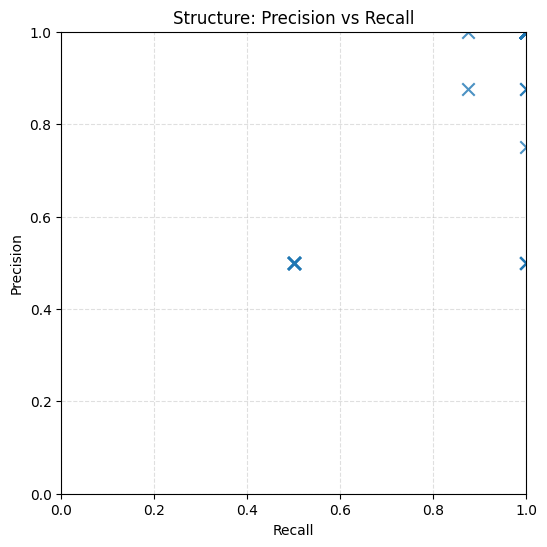

Figure saved to: figures/GPT-5-Mini_scatterplot_structure_precision_recall.png


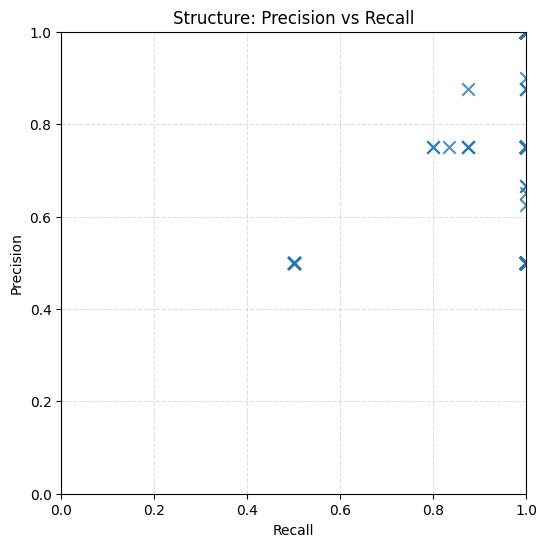

Figure saved to: figures/GPT-5-Nano_scatterplot_structure_precision_recall.png


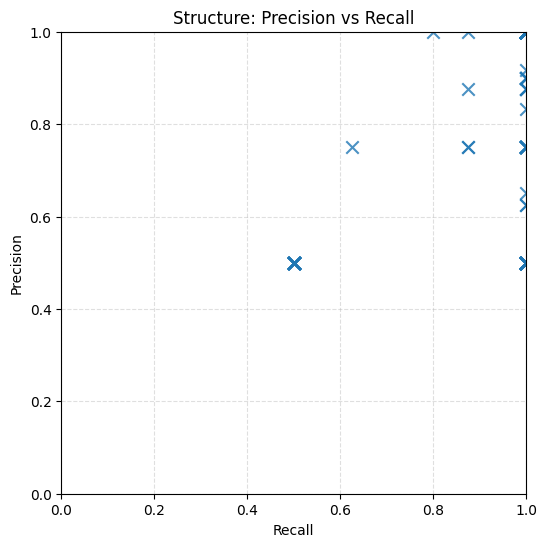

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_hierarchical_recall'
s_prec = 'Structure_hierarchical_precision'

# Generate plots if columns exist
for model_name, df in dfs:    
    if s_rec in df.columns and s_prec in df.columns:
        scatter_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall', figures_dir + f'/{model_name}_scatterplot_structure_precision_recall.png')
    else:
        print('Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_scatterplot_structure_action_precision_recall.png


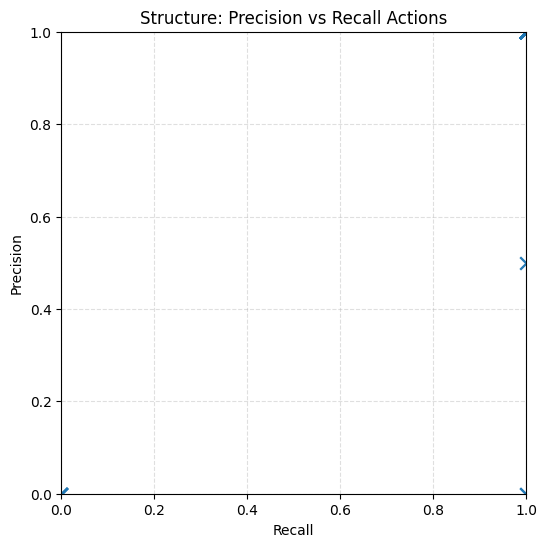

Figure saved to: figures/GPT-5-Mini_scatterplot_structure_action_precision_recall.png


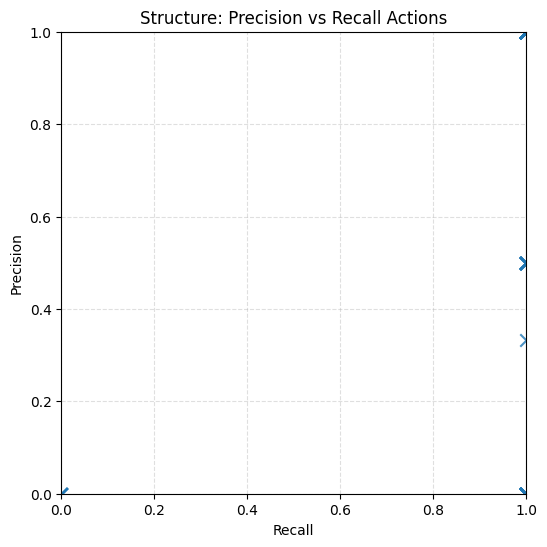

Figure saved to: figures/GPT-5-Nano_scatterplot_structure_action_precision_recall.png


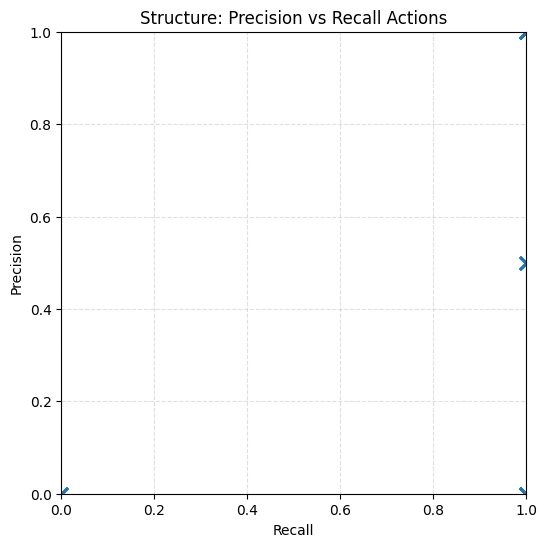

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_act'
s_prec = 'Structure_p_act'

for model_name, df in dfs:    
    if s_rec in df.columns and s_prec in df.columns:
        scatter_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall Actions', figures_dir + f'/{model_name}_scatterplot_structure_action_precision_recall.png')
    else:
        print('Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_scatterplot_structure_parameter_precision_recall.png


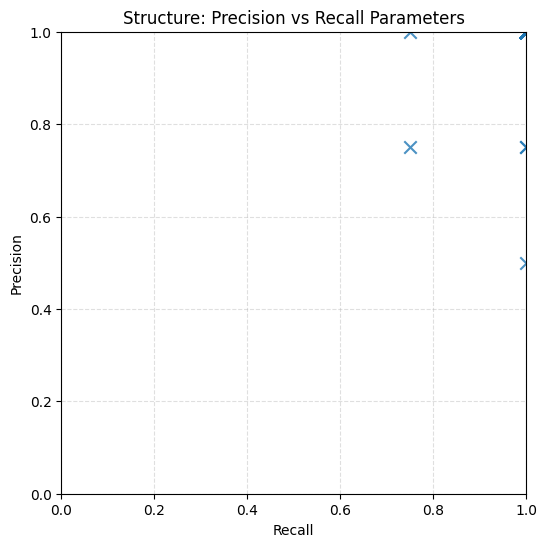

Figure saved to: figures/GPT-5-Mini_scatterplot_structure_parameter_precision_recall.png


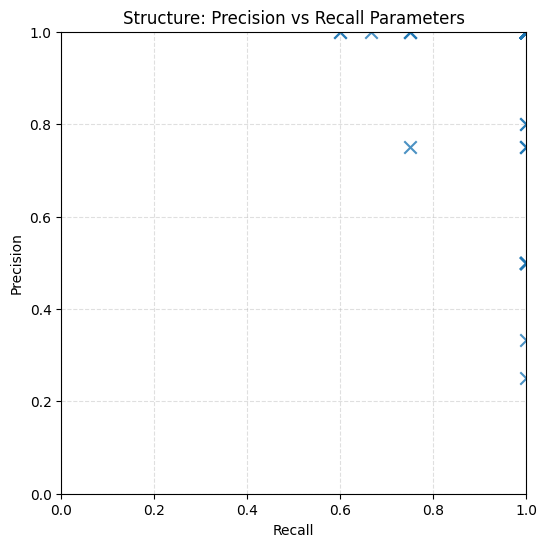

Figure saved to: figures/GPT-5-Nano_scatterplot_structure_parameter_precision_recall.png


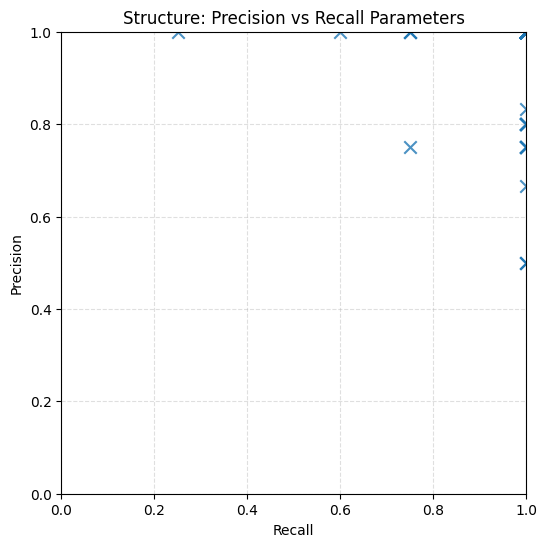

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_par'
s_prec = 'Structure_p_par'

# Generate plots if columns exist
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        scatter_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall Parameters', figures_dir + f'/{model_name}_scatterplot_structure_parameter_precision_recall.png')
    else:
        print('Structure columns not found; skipping structure plot.')

## Precision vs recall boxplot

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

def boxplot_pr(df, precision_col: str, recall_col: str, title: str, out_path, show: bool = True, figsize=(6, 6)):
    """Genera un boxplot comparando Precision y Recall, marca la mediana y resalta outliers."""
    out_path = Path(out_path)
    if precision_col not in df.columns or recall_col not in df.columns:
        raise ValueError(f'Required columns not found: {precision_col}, {recall_col}')

    p = df[precision_col].astype(float).dropna()
    r = df[recall_col].astype(float).dropna()

    data = [p, r]
    labels = ['Precision', 'Recall']

    fig, ax = plt.subplots(figsize=figsize)

    # Styling for boxes, median and outliers
    boxprops = {'facecolor': '#FFFFFF', 'color': '#333333'}
    whiskerprops = {'color': '#666666', 'linewidth': 1}
    capprops = {'color': '#666666', 'linewidth': 1}
    medianprops = {'color': '#1F77B4', 'linewidth': 2}
    flierprops = {'marker': 'o', 'markerfacecolor': '#E74C3C', 'markeredgecolor': '#C0392B', 'markersize': 6, 'alpha': 0.9}

    # Controlamos el ancho del boxplot y lo reutilizamos para dibujar la mediana sin exceder el box
    width = 0.5
    bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)

    # Resaltar medianas con una línea horizontal contenida en los límites del box
    half = width / 2.0
    for i, d in enumerate(data, start=1):
        med = float(pd.Series(d).median())
        left = i - half
        right = i + half
        ax.hlines(med, left, right, colors='#1F77B4', linewidth=2.5, zorder=5)

    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Valor')
    ax.grid(axis='y', linestyle='--', alpha=0.35)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')
    if show:
        display(fig)
    plt.close(fig)

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5.1_boxplot_structure_action_precision_recall.png


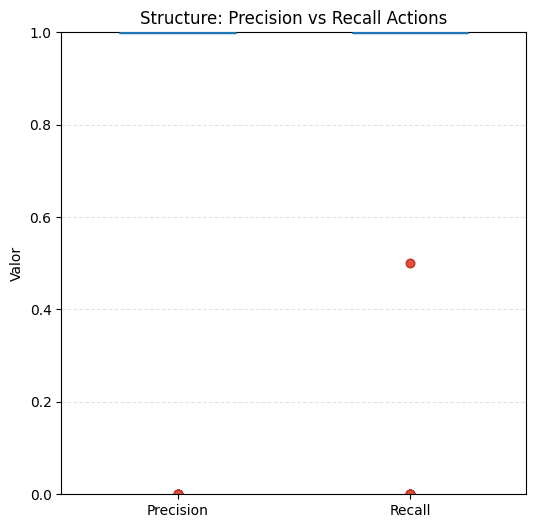

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5-Mini_boxplot_structure_action_precision_recall.png


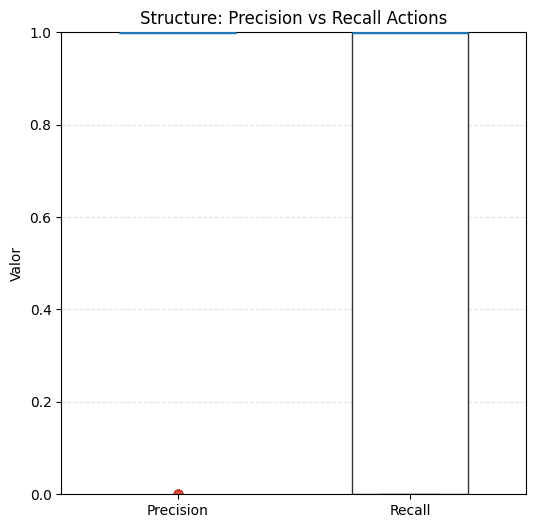

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5-Nano_boxplot_structure_action_precision_recall.png


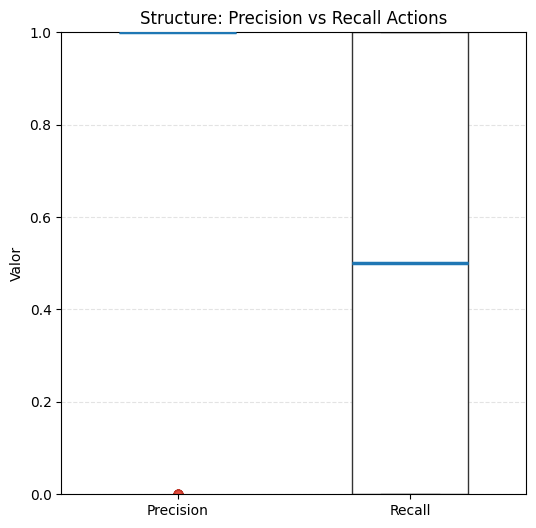

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_act'
s_prec = 'Structure_p_act'

# Generate plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        boxplot_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall Actions', f'{figures_dir}/{model_name}_boxplot_structure_action_precision_recall.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5.1_boxplot_structure_parameter_precision_recall.png


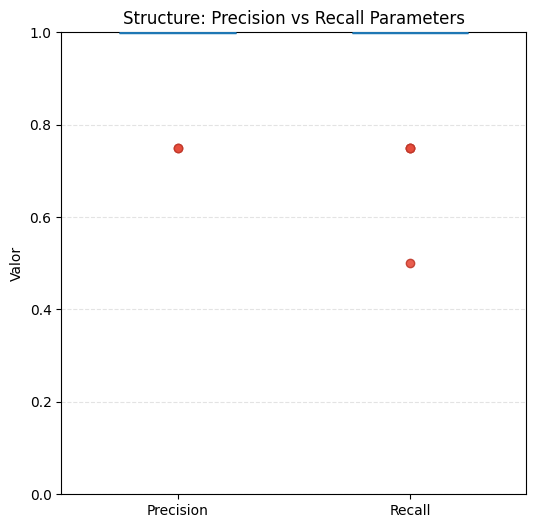

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5-Mini_boxplot_structure_parameter_precision_recall.png


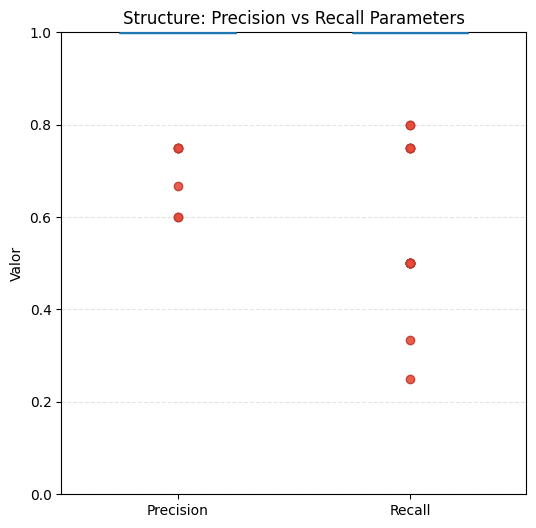

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5-Nano_boxplot_structure_parameter_precision_recall.png


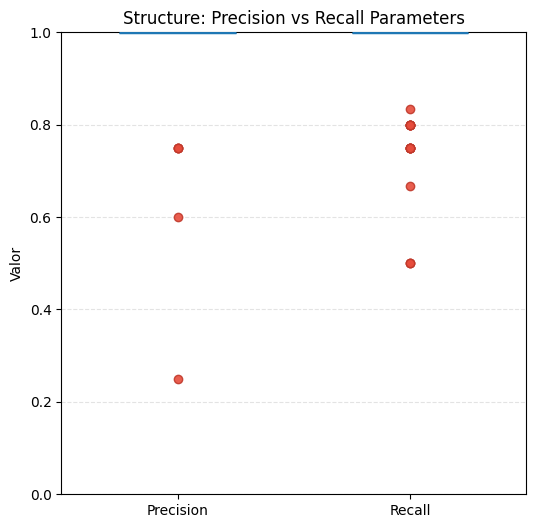

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_par'
s_prec = 'Structure_p_par'

# Generate plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        boxplot_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall Parameters', f'{figures_dir}/{model_name}_boxplot_structure_parameter_precision_recall.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5.1_boxplot_structure.png


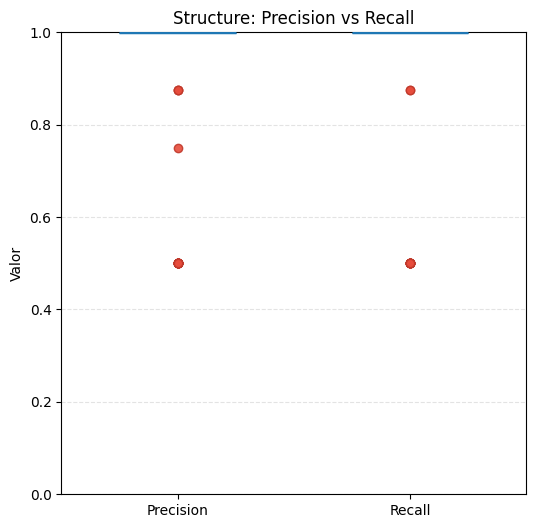

Figure saved to: figures/GPT-5-Mini_boxplot_structure.png


/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


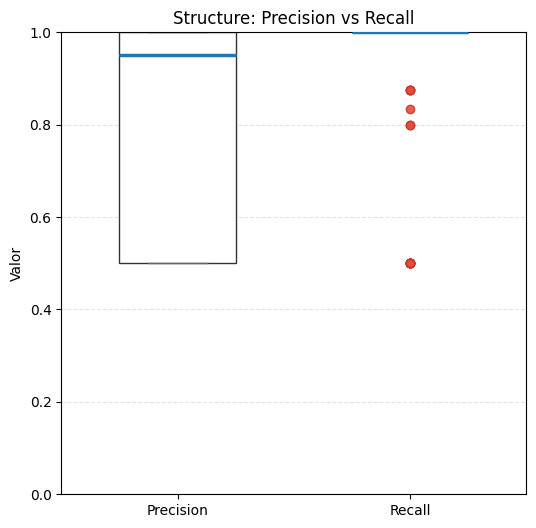

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/613370638.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)


Figure saved to: figures/GPT-5-Nano_boxplot_structure.png


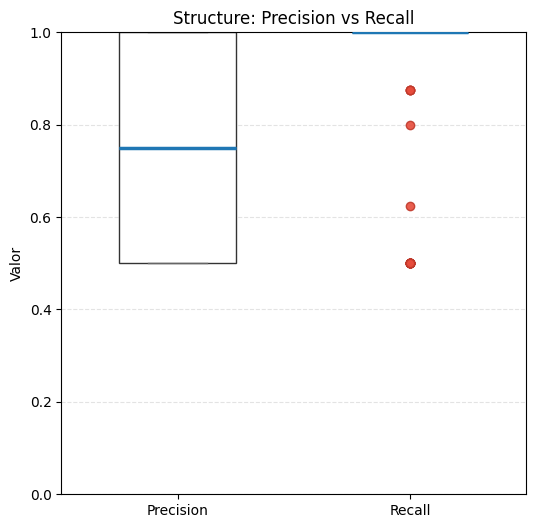

In [ ]:
figures_dir = './figures'
# Generate structure boxplots for all models in dfs
for model_name, df in dfs:
    if 'Structure_hierarchical_precision' in df.columns and 'Structure_hierarchical_recall' in df.columns:
        boxplot_pr(df, 'Structure_hierarchical_precision', 'Structure_hierarchical_recall', 'Structure: Precision vs Recall', f'{figures_dir}/{model_name}_boxplot_structure.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure boxplot.')

## Precision vs recall dumbbell plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

def dumbbell_pr(df, precision_col: str, recall_col: str, title: str, out_path, show: bool = True, id_col: str = 'ID', figsize_per_row: float = 0.18):
    out_path = Path(out_path)
    if precision_col not in df.columns or recall_col not in df.columns:
        raise ValueError(f'Required columns not found: {precision_col}, {recall_col}')

    p = df[precision_col].astype(float).fillna(0)
    r = df[recall_col].astype(float).fillna(0)

    n = len(df)
    height = max(4, n * figsize_per_row)
    fig, ax = plt.subplots(figsize=(8, height))

    ys = np.arange(n)
    for yi, (pv, rv) in enumerate(zip(p, r)):
        ax.plot([pv, rv], [yi, yi], color='#F39C12', linewidth=1.6, alpha=0.9, zorder=1)
    ax.scatter(p, ys, color='#5DA5FF', s=36, zorder=3, label='Precision')
    ax.scatter(r, ys, color='#E07A00', s=36, zorder=4, label='Recall')

    ax.set_xlim(0, 1)
    ax.set_xlabel('Value')
    ax.set_title(title)
    ax.set_yticks(ys)
    labels = df[id_col].tolist() if id_col in df.columns else [str(i) for i in range(1, n+1)]
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.4)

    ax.legend(loc='lower right')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')
    if show:
        display(fig)
    plt.close(fig)

Figure saved to: figures/GPT-5.1_dumbbell_structure_action_precision_recall.png


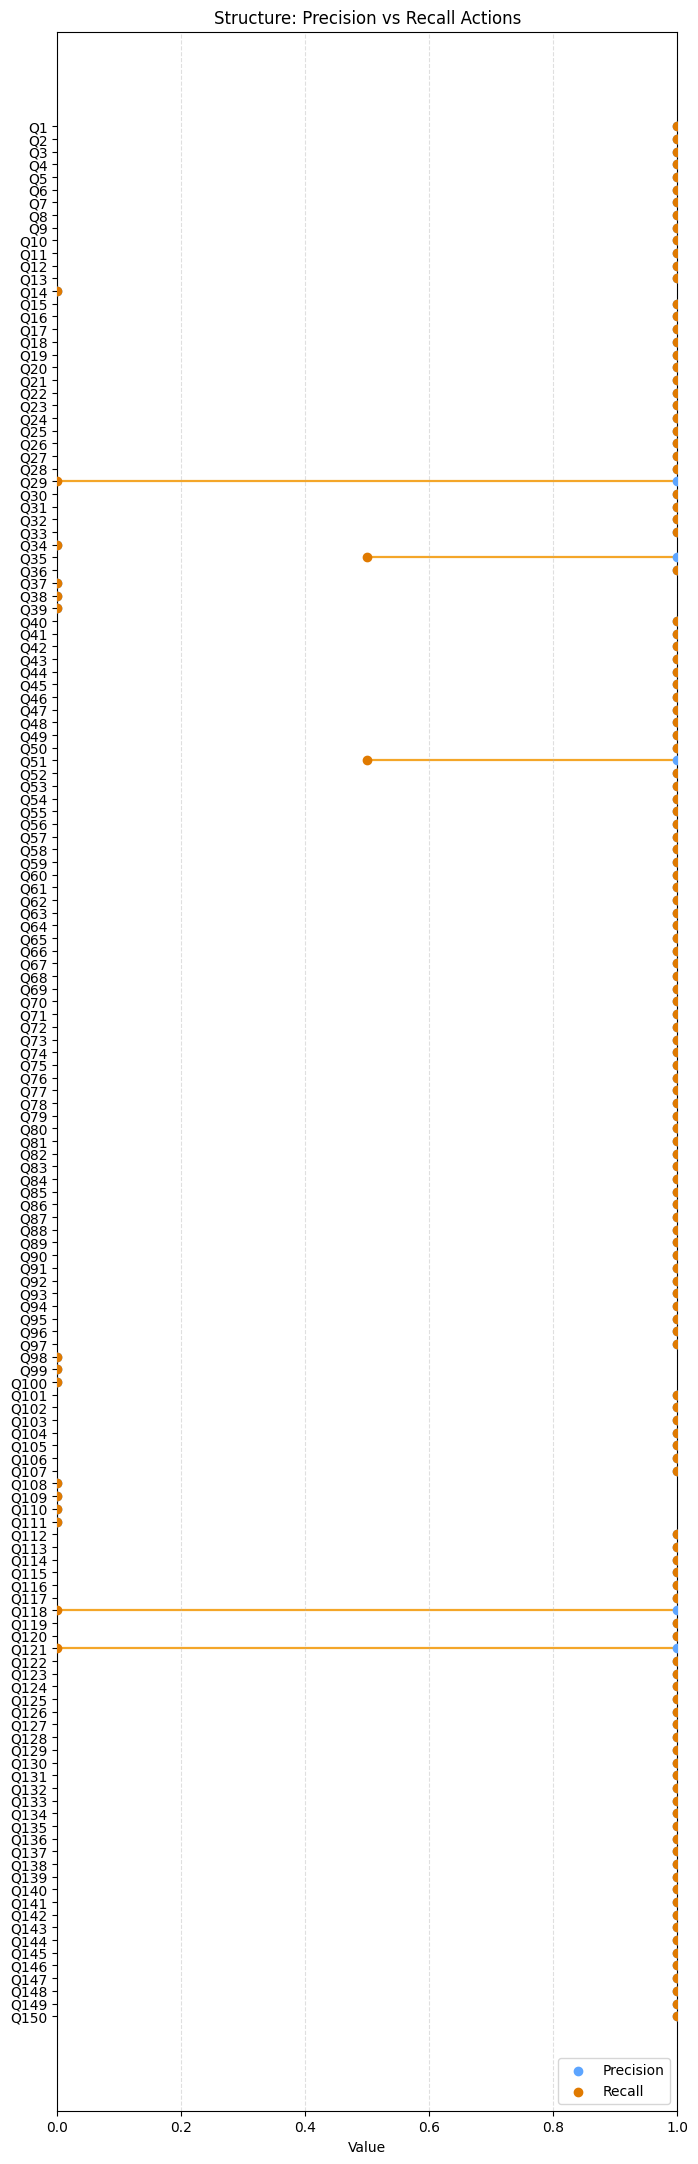

Figure saved to: figures/GPT-5-Mini_dumbbell_structure_action_precision_recall.png


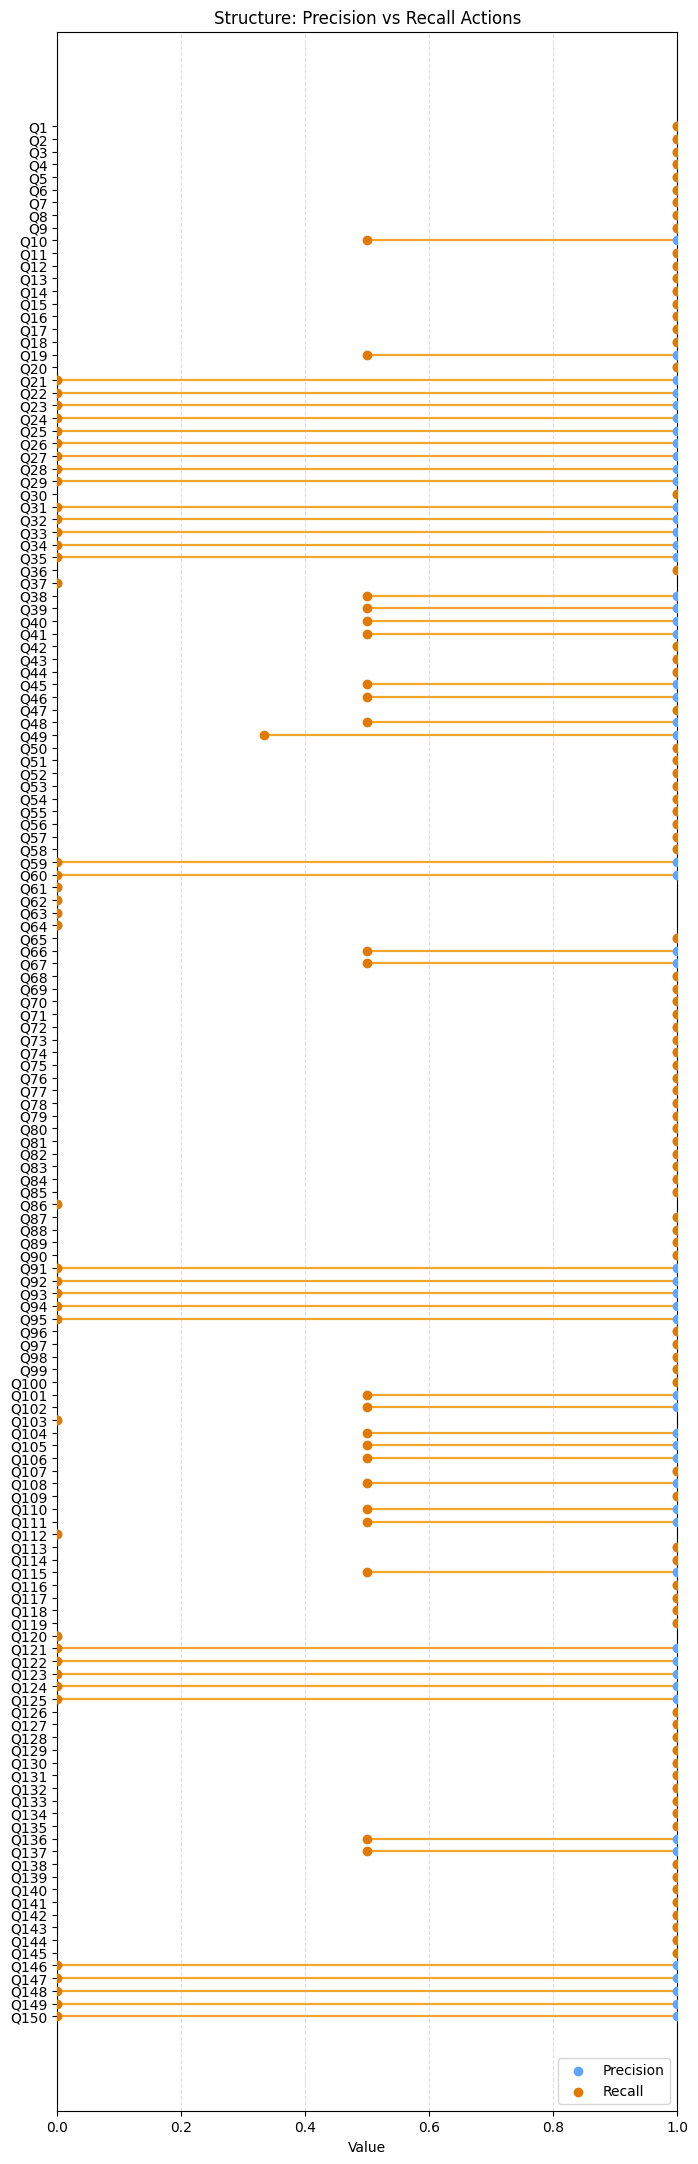

Figure saved to: figures/GPT-5-Nano_dumbbell_structure_action_precision_recall.png


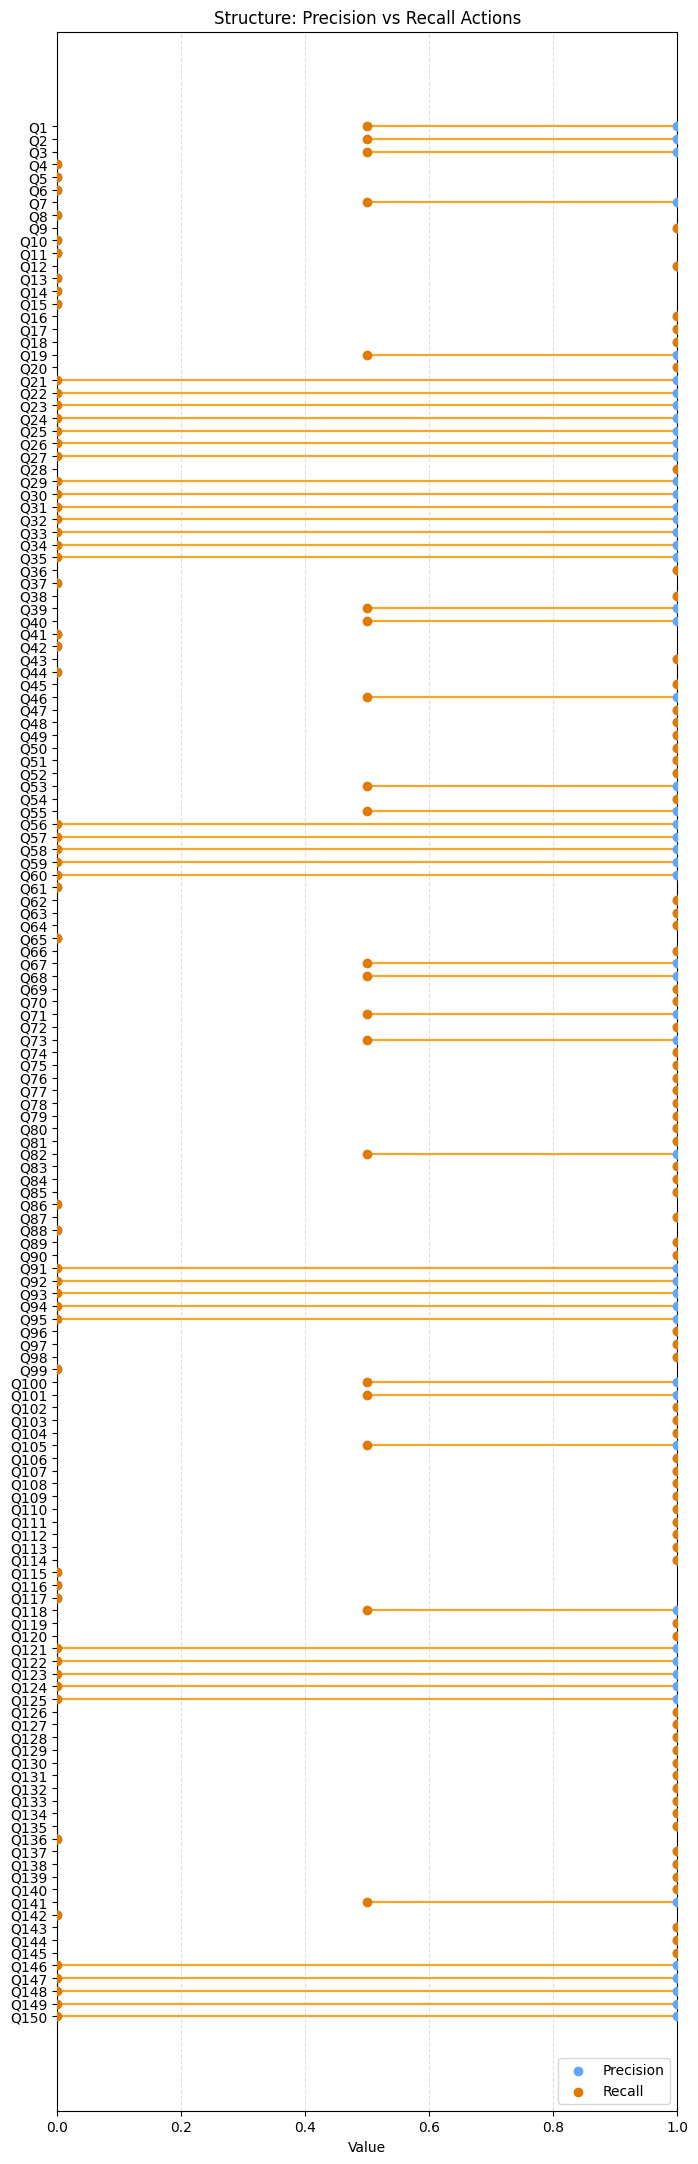

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_act'
s_prec = 'Structure_p_act'

# Generate dumbbell plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        dumbbell_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall Actions', f'{figures_dir}/{model_name}_dumbbell_structure_action_precision_recall.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_dumbbellplot_structure_parameter_precision_recall.png


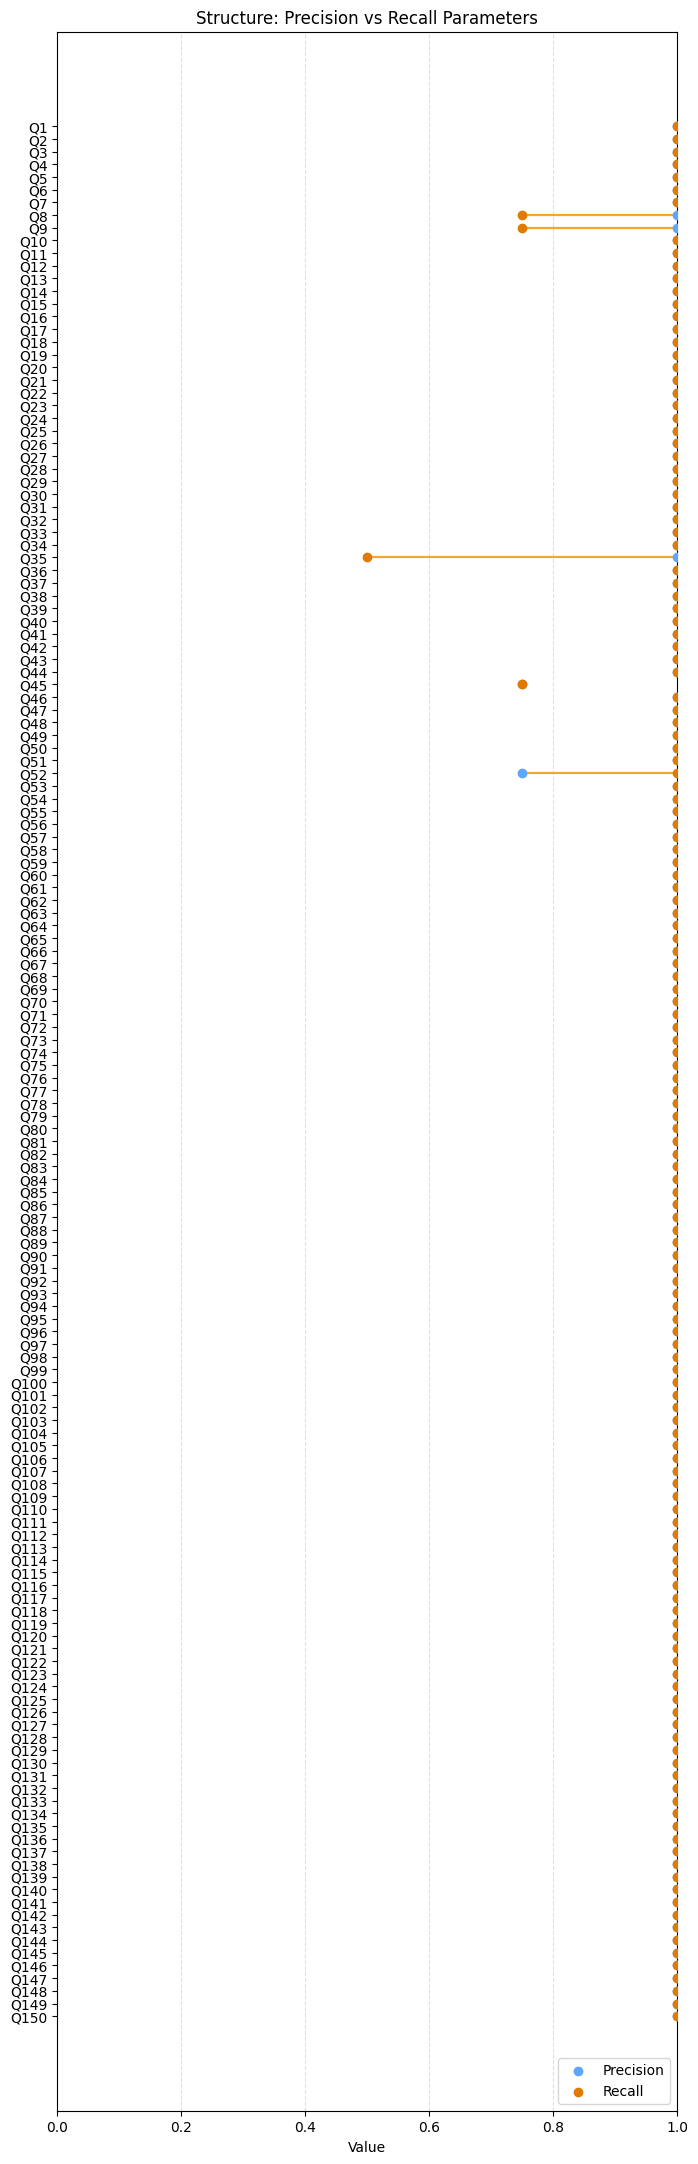

Figure saved to: figures/GPT-5-Mini_dumbbellplot_structure_parameter_precision_recall.png


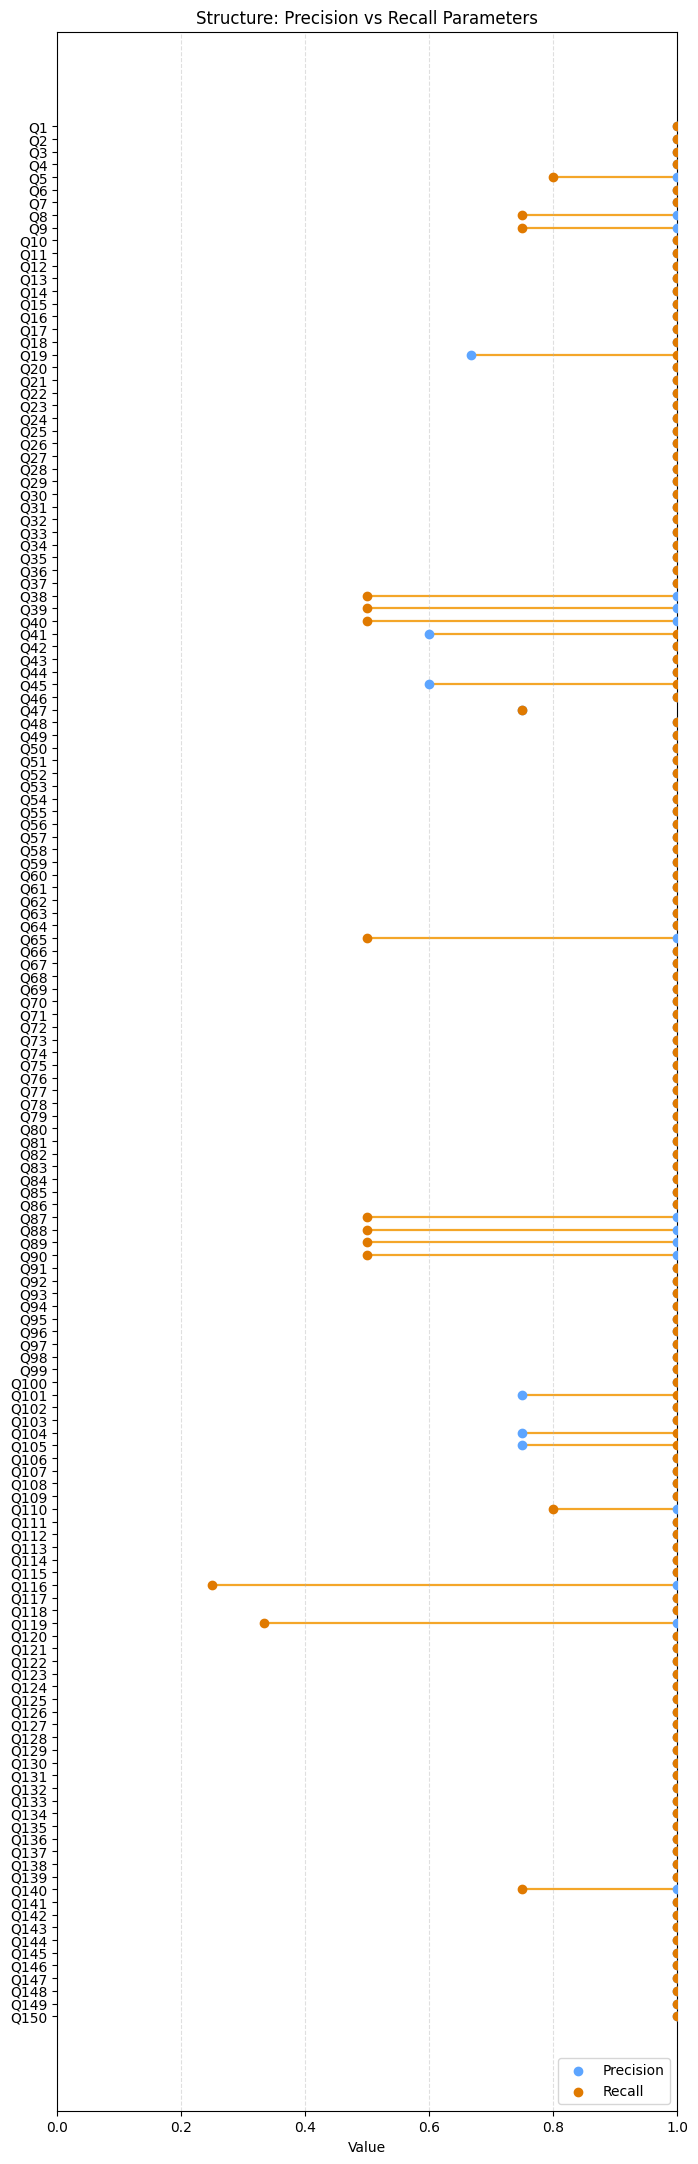

Figure saved to: figures/GPT-5-Nano_dumbbellplot_structure_parameter_precision_recall.png


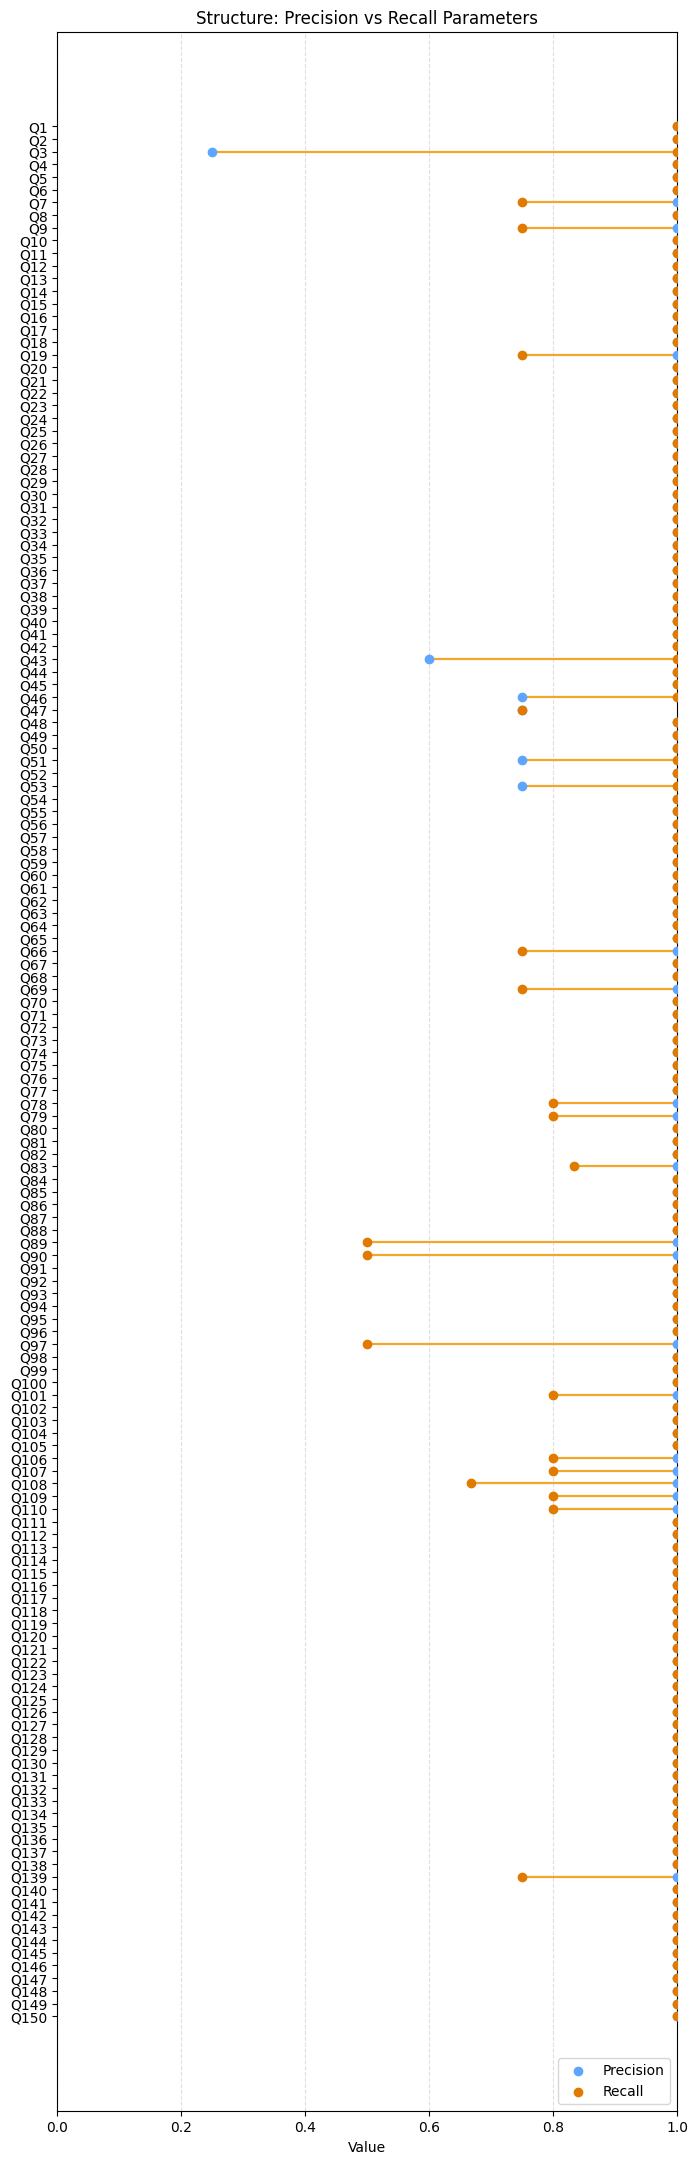

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_par'
s_prec = 'Structure_p_par'

# Generate dumbbell plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        dumbbell_pr(df, s_rec, s_prec, 'Structure: Precision vs Recall Parameters', f'{figures_dir}/{model_name}_dumbbellplot_structure_parameter_precision_recall.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_dumbbell_structure.png


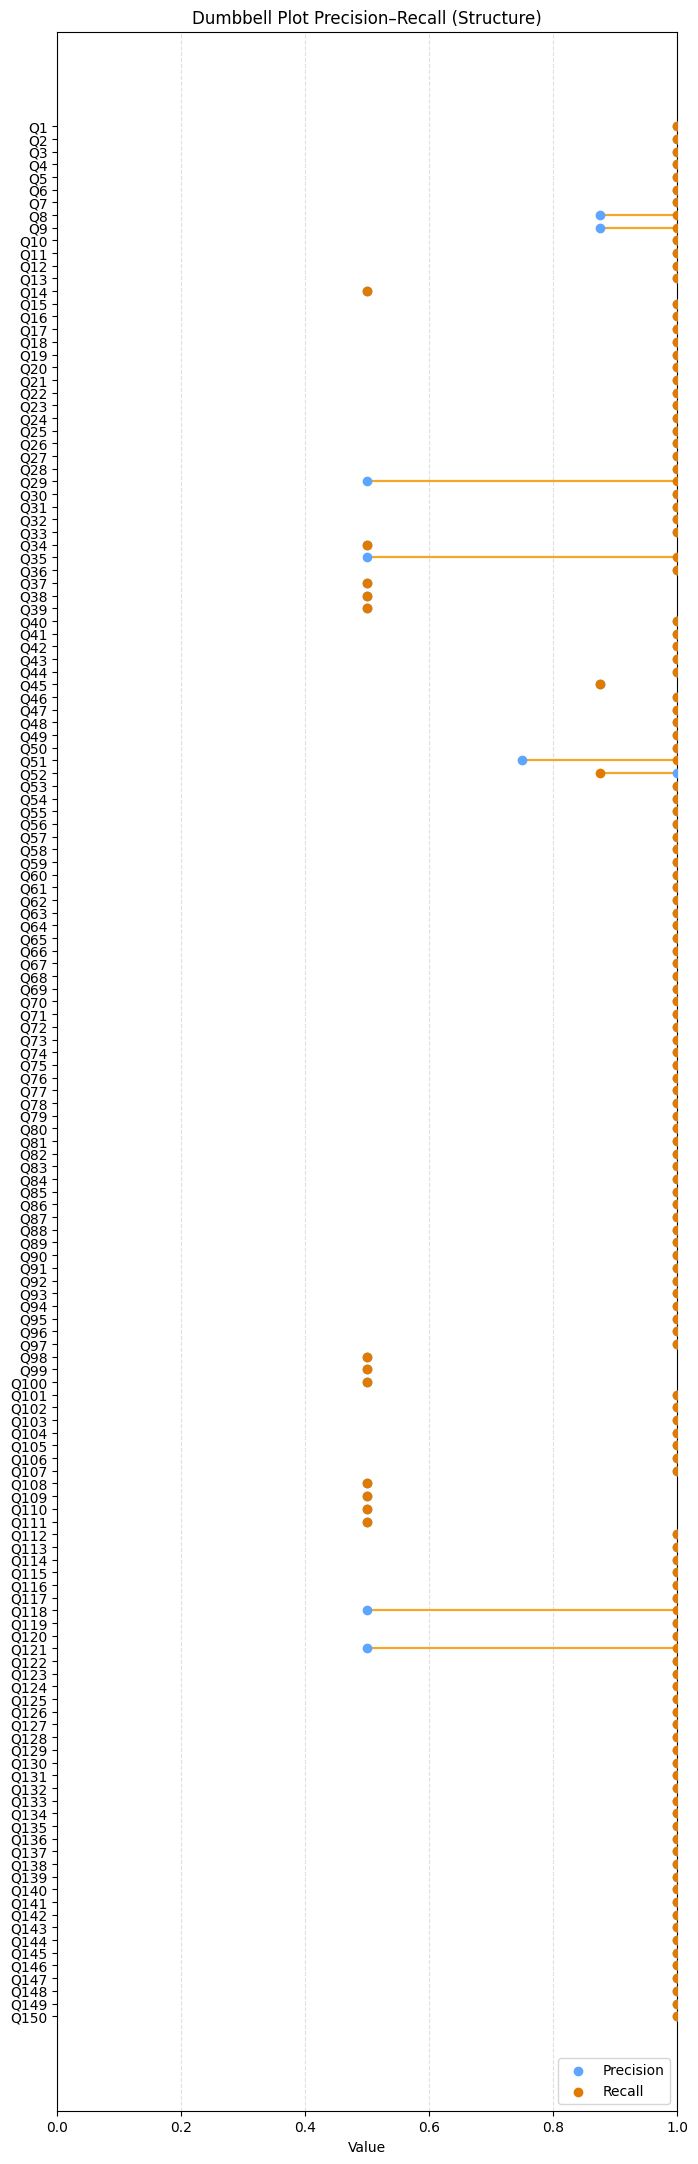

Figure saved to: figures/GPT-5-Mini_dumbbell_structure.png


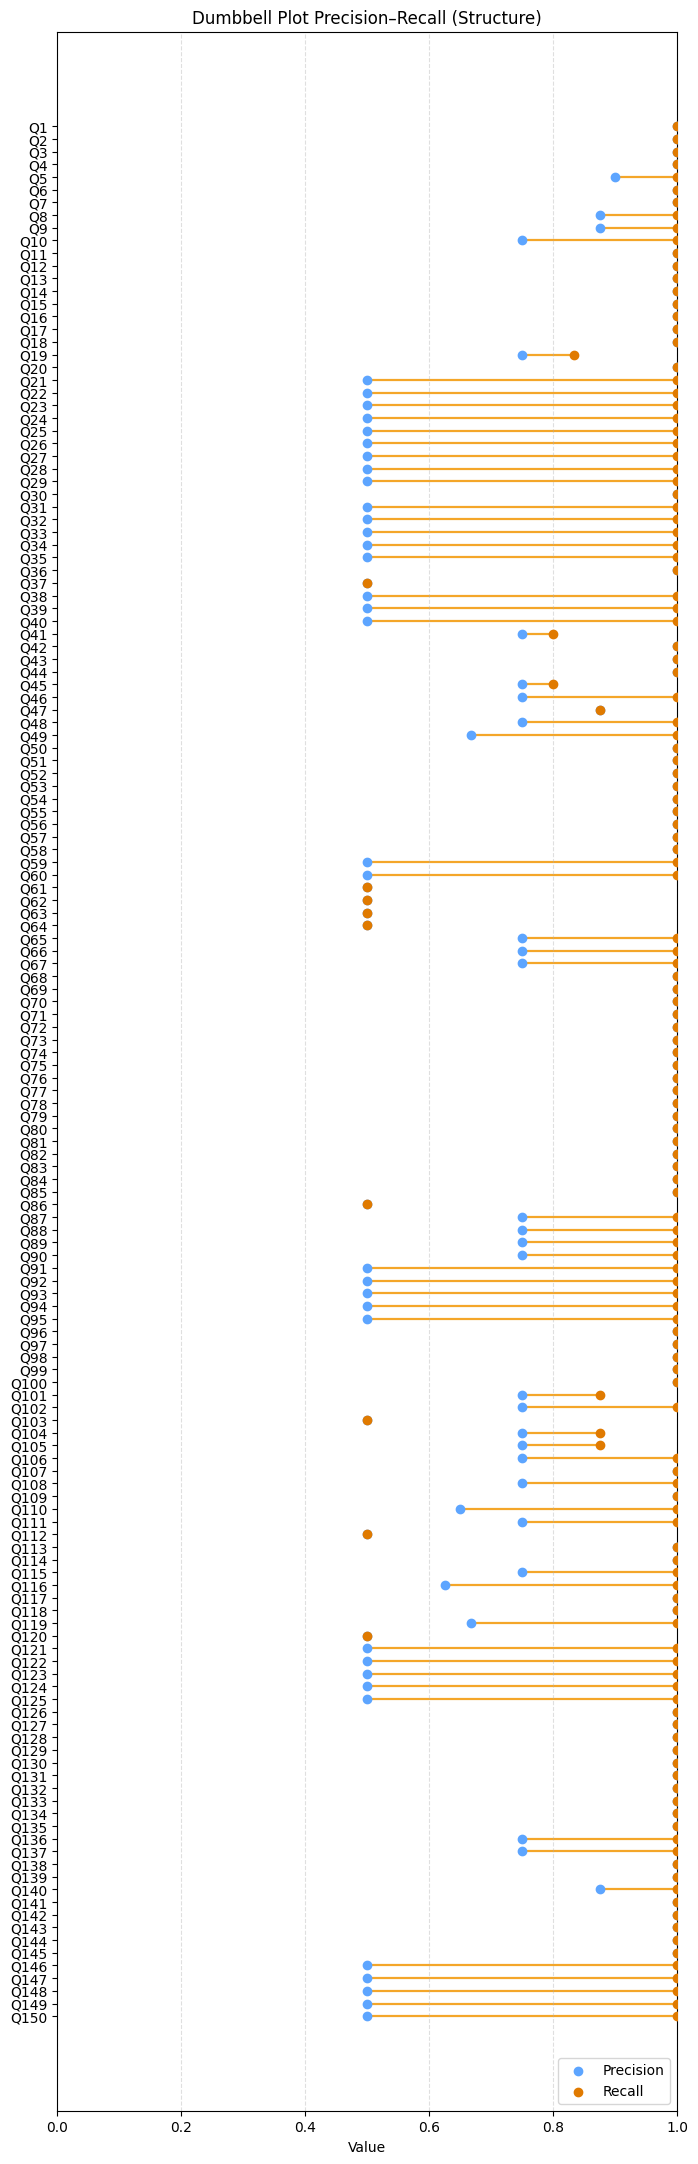

Figure saved to: figures/GPT-5-Nano_dumbbell_structure.png


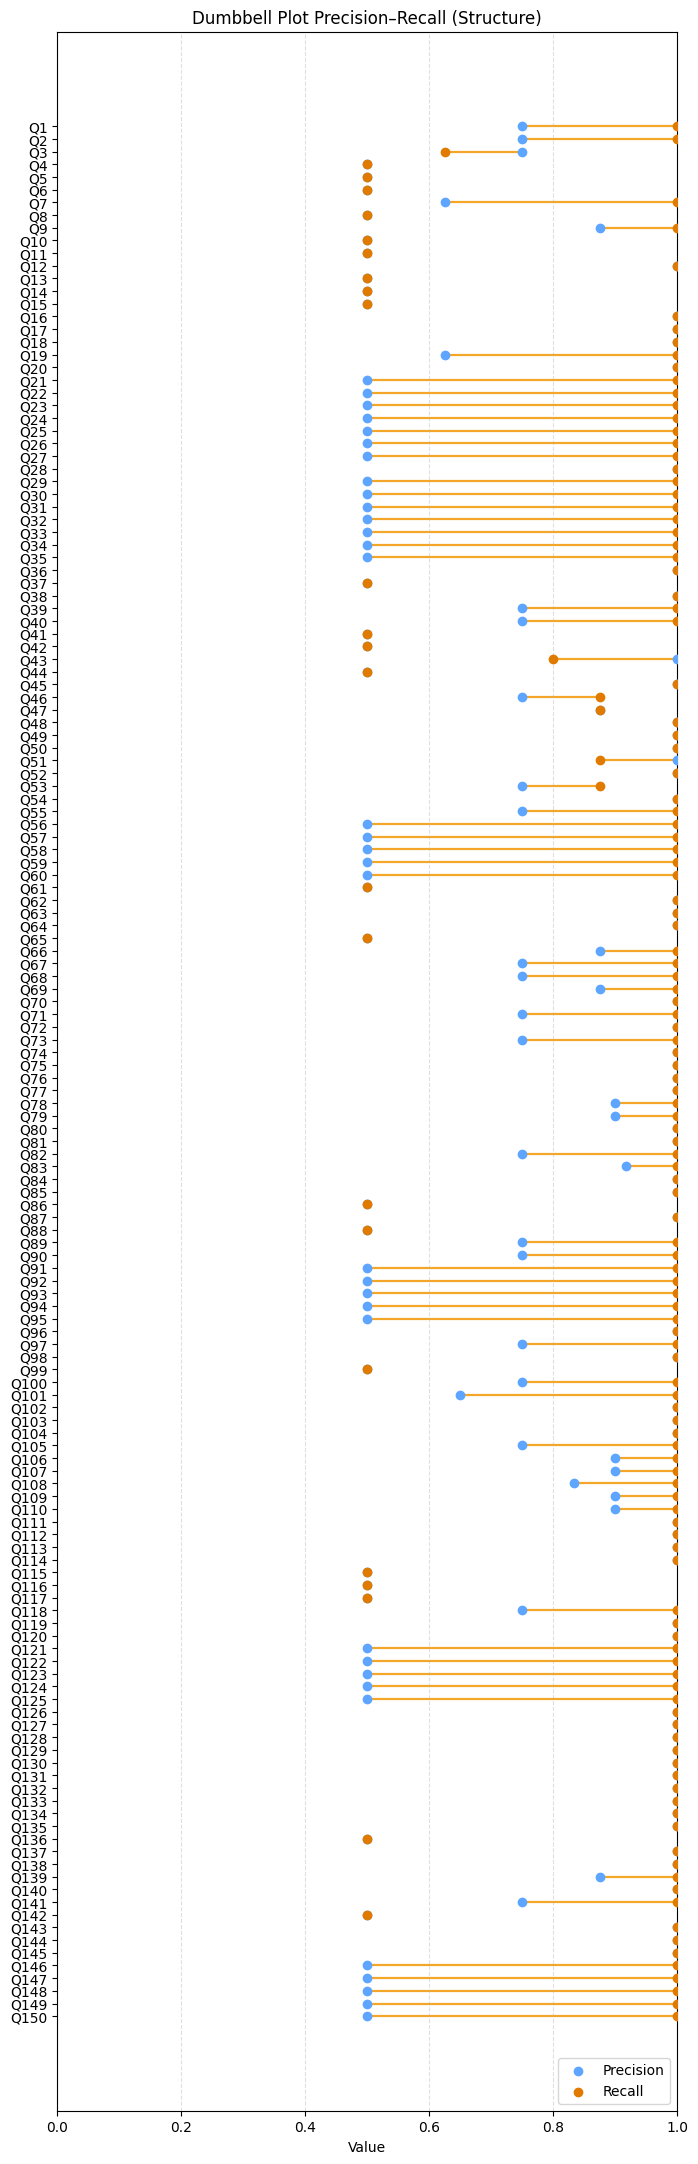

In [ ]:
figures_dir = './figures'
# Generate dumbbell plots for Structure for all models in dfs
for model_name, df in dfs:
    if 'Structure_hierarchical_precision' in df.columns and 'Structure_hierarchical_recall' in df.columns:
        dumbbell_pr(df, 'Structure_hierarchical_precision', 'Structure_hierarchical_recall', 'Dumbbell Plot Precision–Recall (Structure)', f'{figures_dir}/{model_name}_dumbbell_structure.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure dumbbell plot.')

## Precision vs recall violin plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

def violin_pr_structure(
    df, 
    precision_col: str = 'Structure_hierarchical_precision', 
    recall_col: str = 'Structure_hierarchical_recall', 
    title: str = 'Precision vs Recall (Structure)', 
    out_path='./figures/violin_structure.png', 
    show: bool = True, 
    figsize=(8, 6)
):
    """
    Generates a violin plot comparing the distribution of Precision and Recall 
    for the Structure metric only.

    Parameters:
    - df: pandas.DataFrame containing the precision and recall columns for Structure.
    - precision_col, recall_col: names of the columns in df.
    - title: title of the figure.
    - out_path: path where the figure will be saved.
    - show: whether to display the figure in the notebook.
    - figsize: figure size (width, height).
    """

    out_path = Path(out_path)

    if precision_col not in df.columns or recall_col not in df.columns:
        raise ValueError(f'Required columns not found: {precision_col}, {recall_col}')

    # Extract numeric data and drop NaN values
    p = df[precision_col].astype(float).dropna().to_numpy()
    r = df[recall_col].astype(float).dropna().to_numpy()

    # Prepare data for the violin plot: list containing two arrays
    data = [p, r]
    labels = ['Precision', 'Recall']

    fig, ax = plt.subplots(figsize=figsize)

    # Create violin plot and style the components
    parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    # Style violin bodies
    for pc in parts['bodies']:
        pc.set_facecolor('#5DA5FF')
        pc.set_edgecolor('#333333')
        pc.set_alpha(0.85)

    # Axes and labels
    ax.set_xticks([1, 2])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Save figure
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')

    # Display figure if requested
    if show:
        display(fig)

    plt.close(fig)


Figure saved to: figures/GPT-5.1_violinplot_structure_action_precision_recall.png


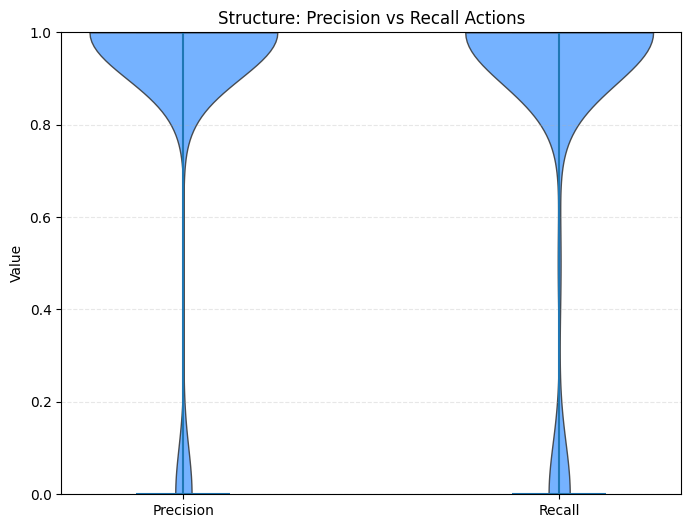

Figure saved to: figures/GPT-5-Mini_violinplot_structure_action_precision_recall.png


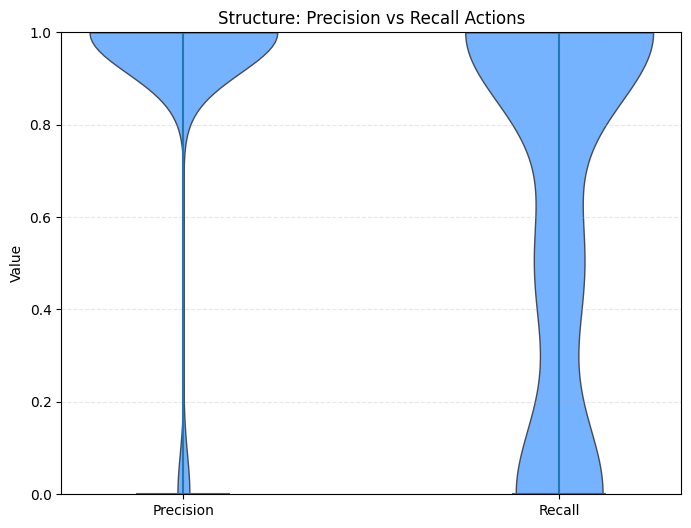

Figure saved to: figures/GPT-5-Nano_violinplot_structure_action_precision_recall.png


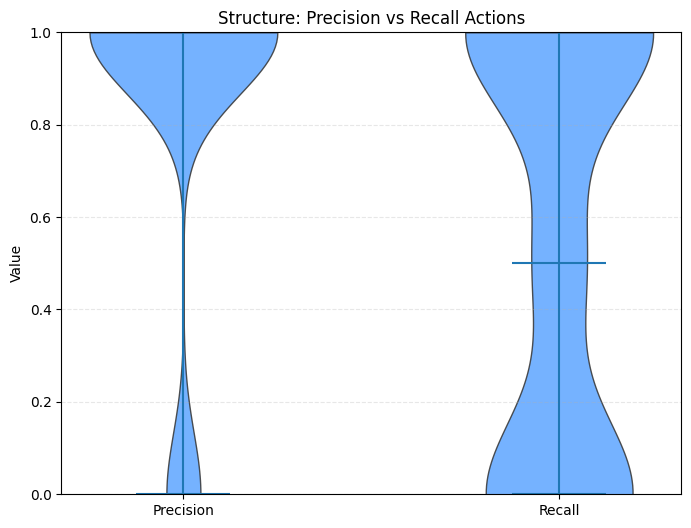

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_act'
s_prec = 'Structure_p_act'

# Generate violin plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        violin_pr_structure(df, s_rec, s_prec, 'Structure: Precision vs Recall Actions', f'{figures_dir}/{model_name}_violinplot_structure_action_precision_recall.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_violinplot_structure_parameter_precision_recall.png


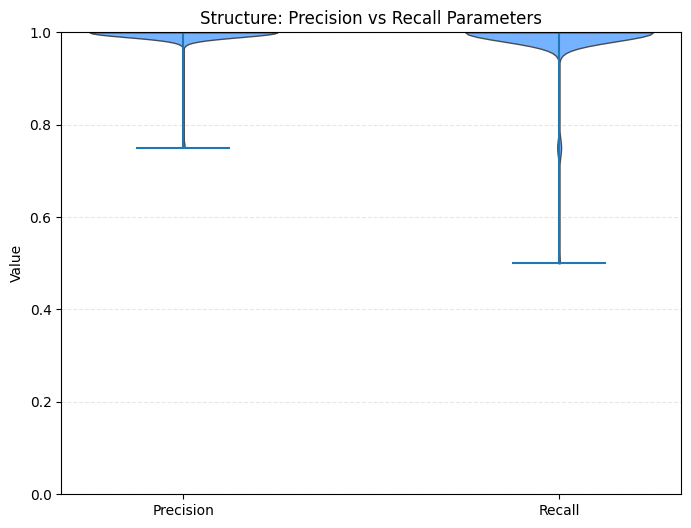

Figure saved to: figures/GPT-5-Mini_violinplot_structure_parameter_precision_recall.png


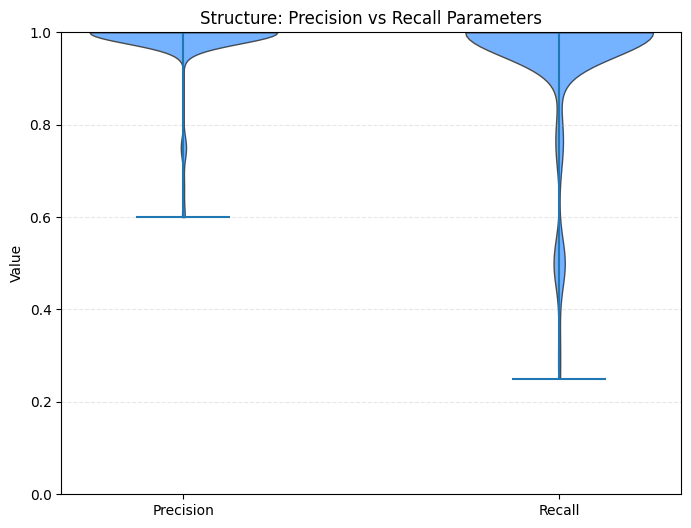

Figure saved to: figures/GPT-5-Nano_violinplot_structure_parameter_precision_recall.png


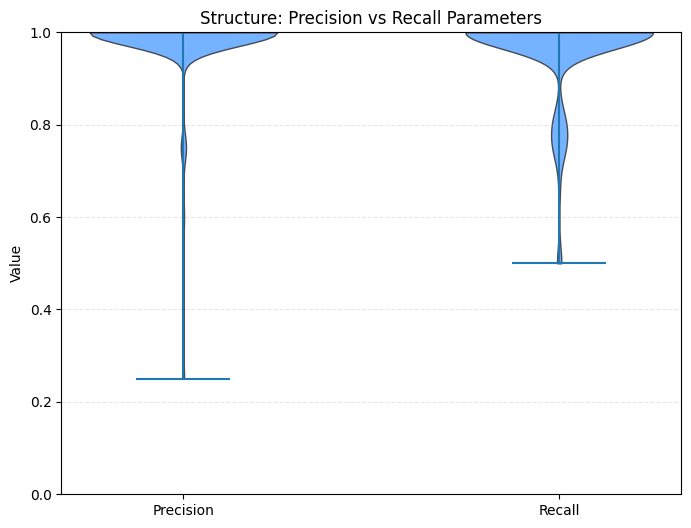

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_par'
s_prec = 'Structure_p_par'

# Generate violin plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        violin_pr_structure(df, s_rec, s_prec, 'Structure: Precision vs Recall Parameters', f'{figures_dir}/{model_name}_violinplot_structure_parameter_precision_recall.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_violin_structure.png


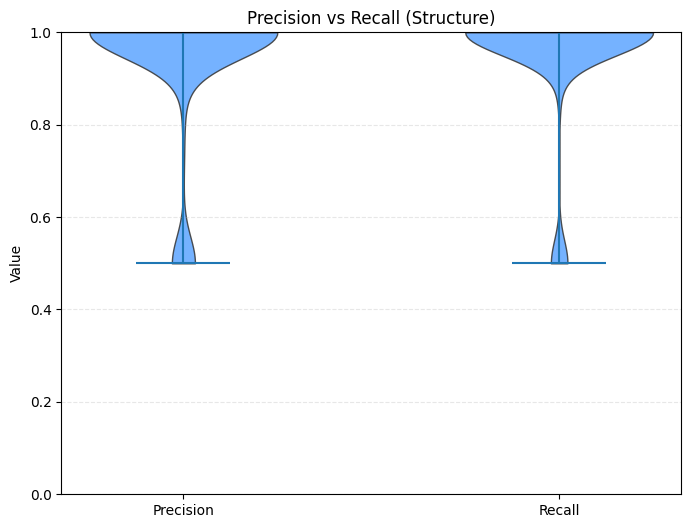

Figure saved to: figures/GPT-5-Mini_violin_structure.png


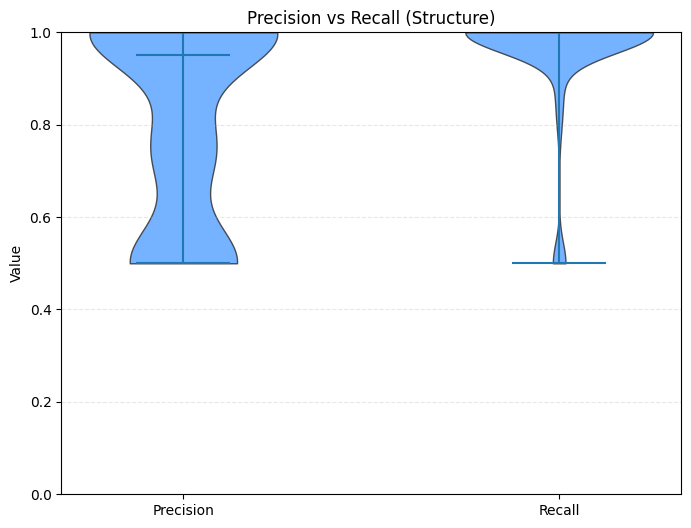

Figure saved to: figures/GPT-5-Nano_violin_structure.png


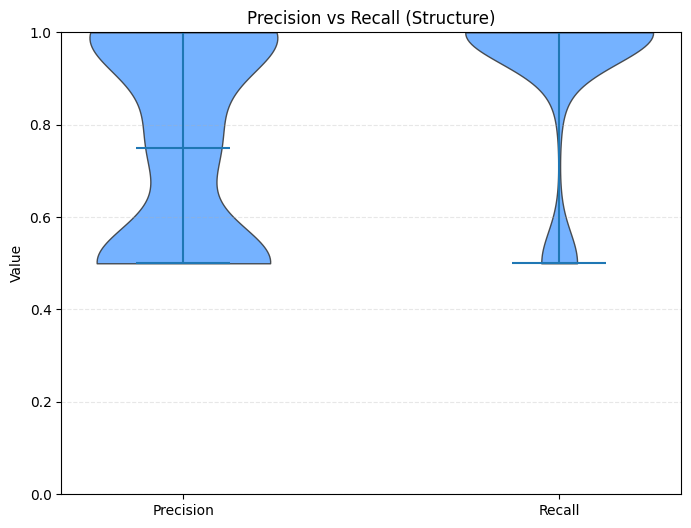

In [ ]:
figures_dir = './figures'
# Generate violin structure plots for all models in dfs
for model_name, df in dfs:
    if 'Structure_hierarchical_precision' in df.columns and 'Structure_hierarchical_recall' in df.columns:
        violin_pr_structure(df, out_path=Path(f'{figures_dir}/{model_name}_violin_structure.png'))
    else:
        print(f'{model_name}: Structure columns not found; skipping violin plot for Structure.')

## F1 score scatter plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

def scatter_pr_f1(df, recall_col: str, precision_col: str, title: str, out_path, show: bool = True, cmap: str = 'viridis', marker: str = 'x', label_fontsize: int = 14, tick_fontsize: int = 12, colorbar_labelsize: int = 12):
    """Scatter plot Precision vs Recall coloreado por F1.

    Parámetros:
    - df: DataFrame con las columnas de precision y recall.
    - recall_col, precision_col: nombres de columnas en df (recall, precision).
    - title: título de la figura.
    - out_path: ruta (file o Path) donde guardar la imagen.
    - show: si mostrar la figura en el notebook.
    """
    out_path = Path(out_path)
    if recall_col not in df.columns or precision_col not in df.columns:
        raise ValueError(f'Required columns not found: {recall_col}, {precision_col}')

    # Obtener series numéricas
    r = df[recall_col].astype(float).fillna(0).to_numpy()
    p = df[precision_col].astype(float).fillna(0).to_numpy()

    # Calcular F1 evitando división por cero
    denom = (p + r)
    f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)

    fig, ax = plt.subplots(figsize=(9, 6))
    sc = ax.scatter(p, r, c=f1, cmap=cmap, s=60, marker=marker, alpha=0.9, linewidths=0.6)

    ax.set_xlabel('Precision', fontsize=label_fontsize)
    ax.set_ylabel('Recall', fontsize=label_fontsize)
    # Title intentionally omitted to reduce clutter
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('F1-score', fontsize=colorbar_labelsize)
    cbar.ax.tick_params(labelsize=tick_fontsize)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')
    if show:
        display(fig)
    plt.close(fig)

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/3811551713.py:26: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)


Figure saved to: figures/GPT-5.1_scatter_structure_action_f1.png


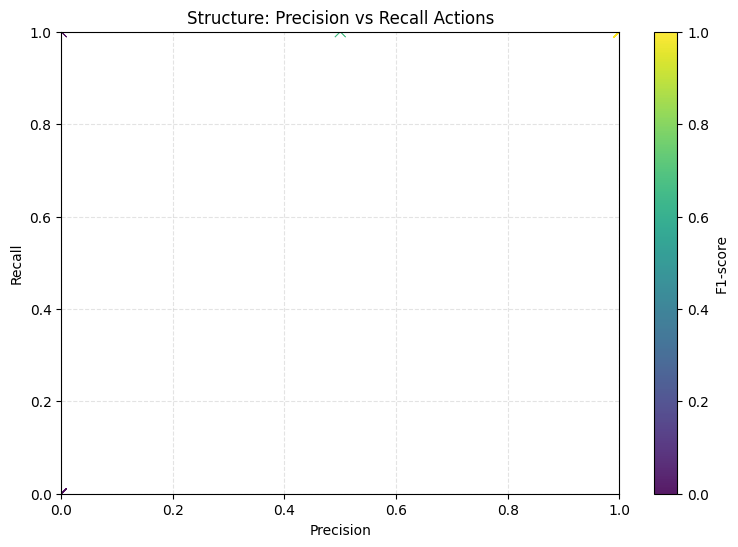

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/3811551713.py:26: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)


Figure saved to: figures/GPT-5-Mini_scatter_structure_action_f1.png


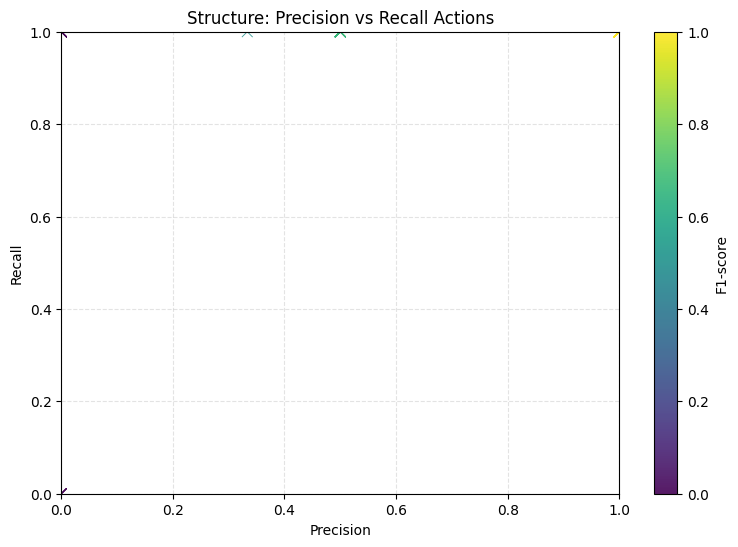

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/3811551713.py:26: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)


Figure saved to: figures/GPT-5-Nano_scatter_structure_action_f1.png


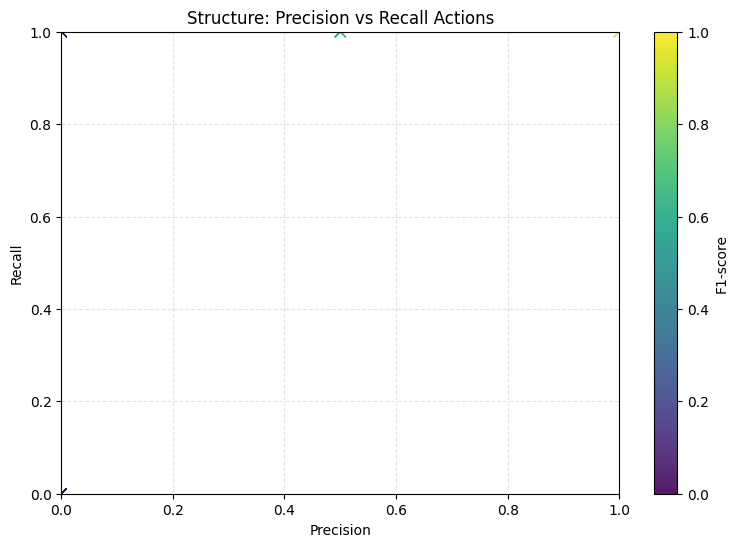

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_act'
s_prec = 'Structure_p_act'

# Generate F1-colored scatter plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        scatter_pr_f1(df, s_rec, s_prec, 'Structure: Precision vs Recall Actions', f'{figures_dir}/{model_name}_scatter_structure_action_f1.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_scatter_structure_parameter_f1.png


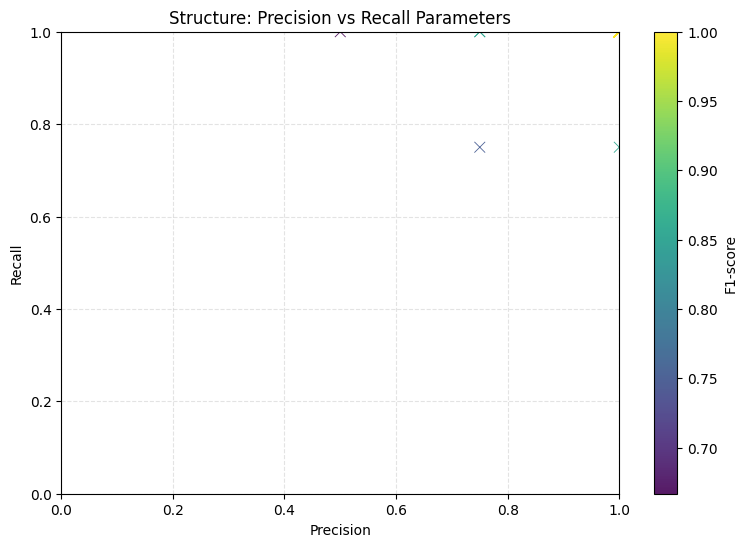

Figure saved to: figures/GPT-5-Mini_scatter_structure_parameter_f1.png


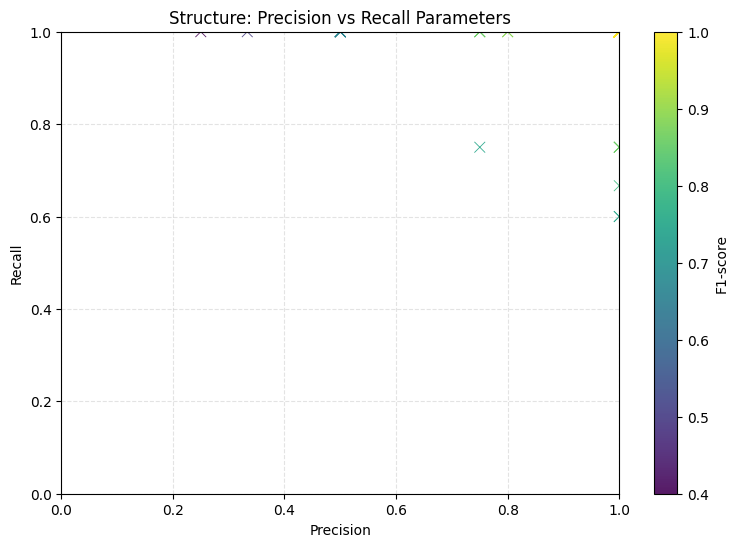

Figure saved to: figures/GPT-5-Nano_scatter_structure_parameter_f1.png


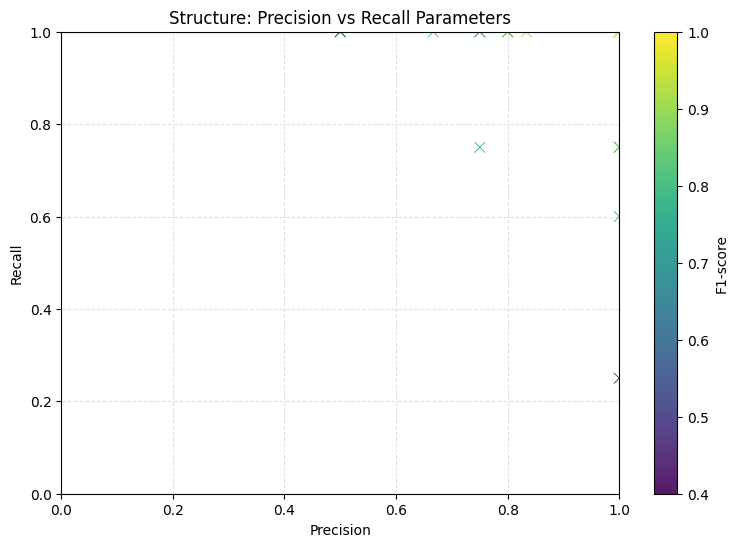

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_par'
s_prec = 'Structure_p_par'

# Generate F1-colored scatter plots for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        scatter_pr_f1(df, s_rec, s_prec, 'Structure: Precision vs Recall Parameters', f'{figures_dir}/{model_name}_scatter_structure_parameter_f1.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_scatter_structure_f1.png


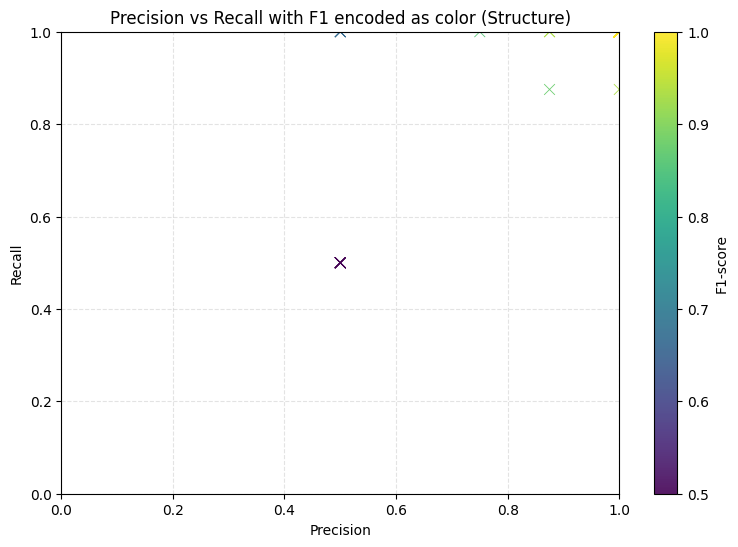

Figure saved to: figures/GPT-5-Mini_scatter_structure_f1.png


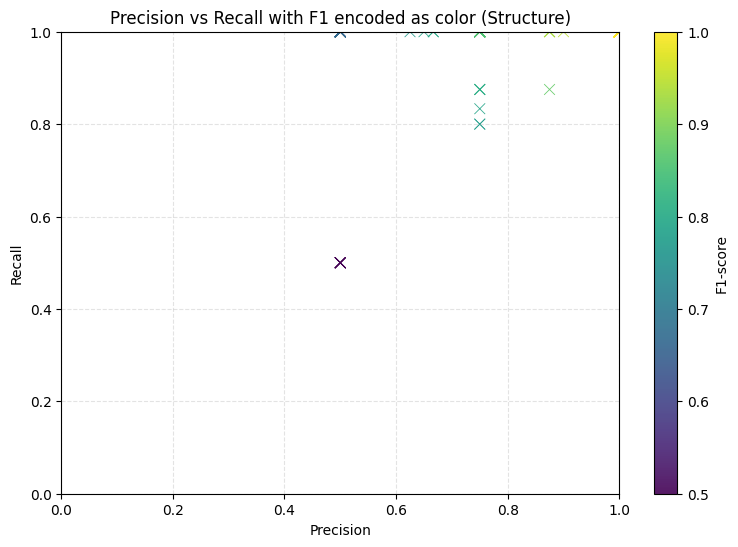

Figure saved to: figures/GPT-5-Nano_scatter_structure_f1.png


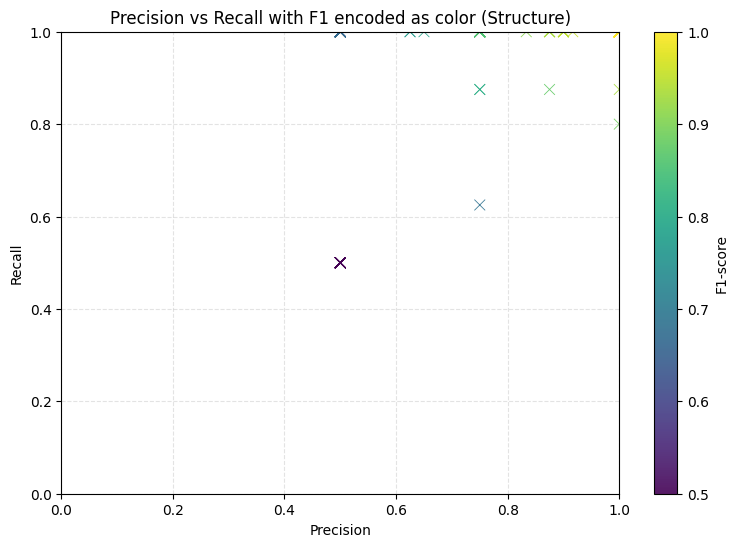

In [ ]:
figures_dir = './figures'
# Generate F1 scatter (structure) for all models in dfs
for model_name, df in dfs:
    if 'Structure_hierarchical_precision' in df.columns and 'Structure_hierarchical_recall' in df.columns:
        scatter_pr_f1(df, 'Structure_hierarchical_recall', 'Structure_hierarchical_precision', 'Precision vs Recall with F1 encoded as color (Structure)', f'{figures_dir}/{model_name}_scatter_structure_f1.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping Structure F1 scatter.')

## F1 score histogram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

def hist_f1(df, precision_col: str, recall_col: str, title: str, out_path, bins: int = 20, show: bool = True, color: str = '#5DA5FF'):
    """Genera un histograma de F1 calculado desde precision y recall.

    Parámetros:
    - df: pandas.DataFrame con las columnas de precision y recall.
    - precision_col, recall_col: nombres de las columnas en df.
    - title: título de la figura.
    - out_path: ruta donde guardar la imagen.
    - bins: número de bins del histograma.
    - show: mostrar la figura en el notebook.
    """
    out_path = Path(out_path)
    if precision_col not in df.columns or recall_col not in df.columns:
        raise ValueError(f'Required columns not found: {precision_col}, {recall_col}')

    p = df[precision_col].astype(float).fillna(0).to_numpy()
    r = df[recall_col].astype(float).fillna(0).to_numpy()

    denom = (p + r)
    f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(f1, bins=bins, color=color, edgecolor='#222222', alpha=0.95)

    ax.set_xlim(0, 1)
    ax.set_xlabel('F1-score')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')
    if show:
        display(fig)
    plt.close(fig)

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/2435308343.py:25: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)


Figure saved to: figures/GPT-5.1_hist_structure_action_f1.png


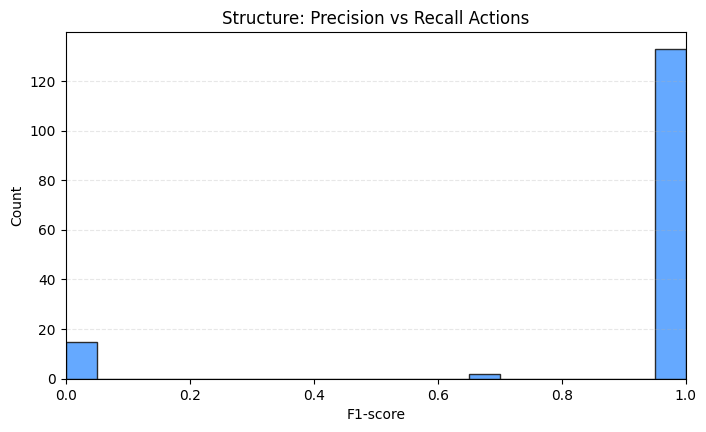

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/2435308343.py:25: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)


Figure saved to: figures/GPT-5-Mini_hist_structure_action_f1.png


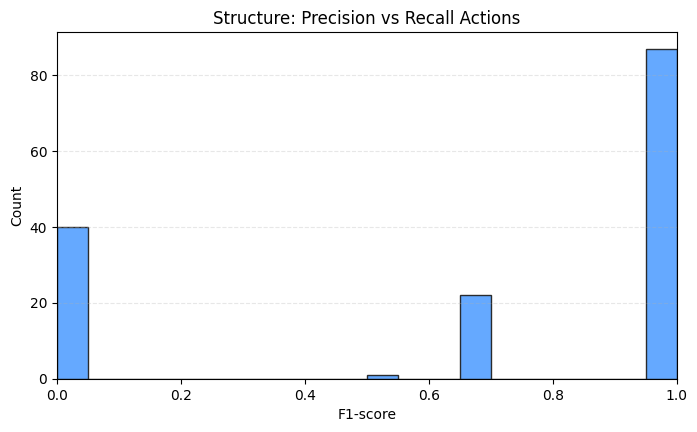

/var/folders/86/wc8z6d053775034n2_2vv1bh0000gn/T/ipykernel_9343/2435308343.py:25: RuntimeWarning: invalid value encountered in divide
  f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)


Figure saved to: figures/GPT-5-Nano_hist_structure_action_f1.png


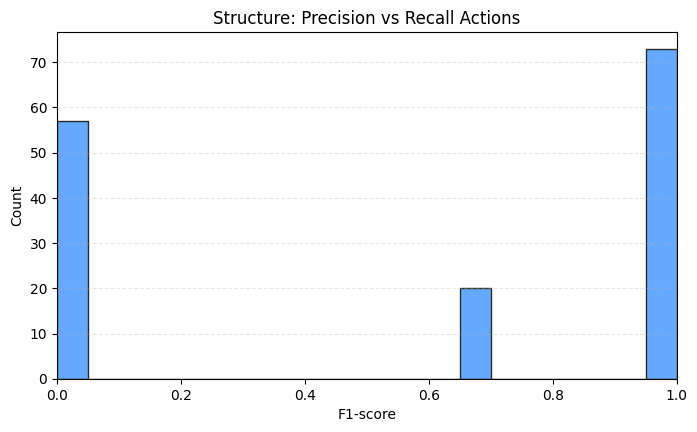

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_act'
s_prec = 'Structure_p_act'

# Generate F1 histograms for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        hist_f1(df, s_rec, s_prec, 'Structure: Precision vs Recall Actions', f'{figures_dir}/{model_name}_hist_structure_action_f1.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_hist_structure_parameter_f1.png


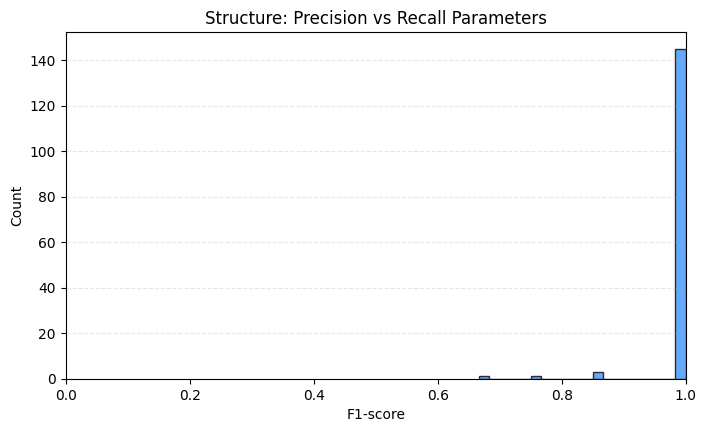

Figure saved to: figures/GPT-5-Mini_hist_structure_parameter_f1.png


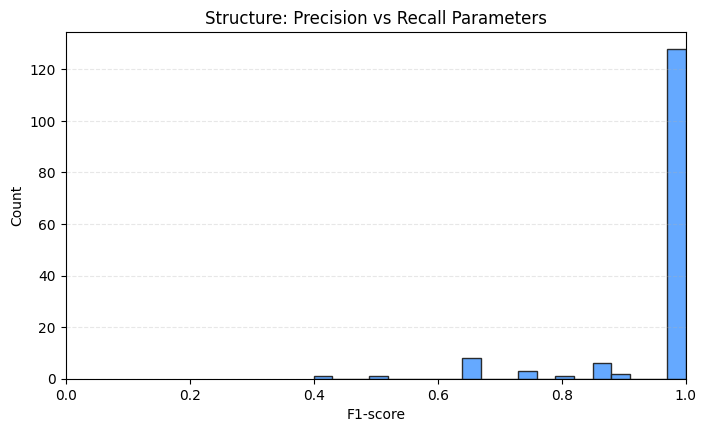

Figure saved to: figures/GPT-5-Nano_hist_structure_parameter_f1.png


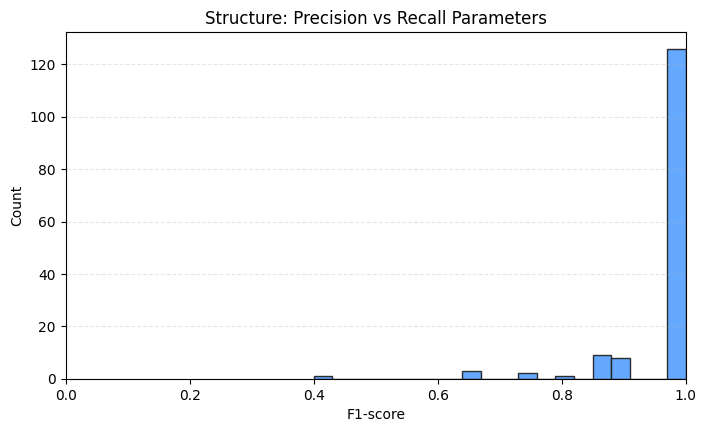

In [ ]:
figures_dir = './figures'

s_rec = 'Structure_r_par'
s_prec = 'Structure_p_par'

# Generate F1 histograms for all models in dfs
for model_name, df in dfs:
    if s_rec in df.columns and s_prec in df.columns:
        hist_f1(df, s_rec, s_prec, 'Structure: Precision vs Recall Parameters', f'{figures_dir}/{model_name}_hist_structure_parameter_f1.png')
    else:
        print(f'{model_name}: Structure columns not found; skipping structure plot.')

Figure saved to: figures/GPT-5.1_hist_f1_structure.png


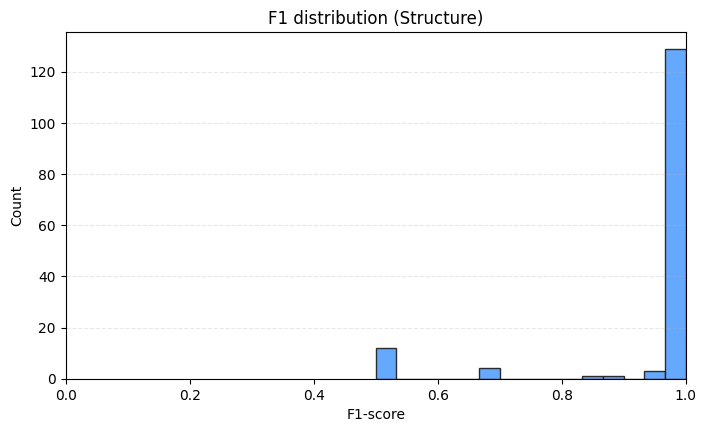

Figure saved to: figures/GPT-5-Mini_hist_f1_structure.png


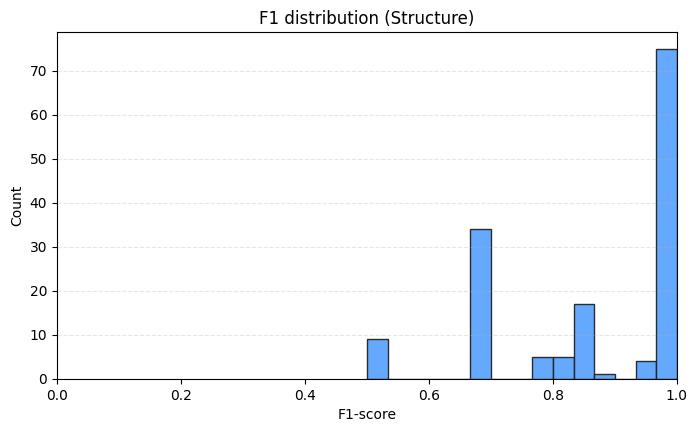

Figure saved to: figures/GPT-5-Nano_hist_f1_structure.png


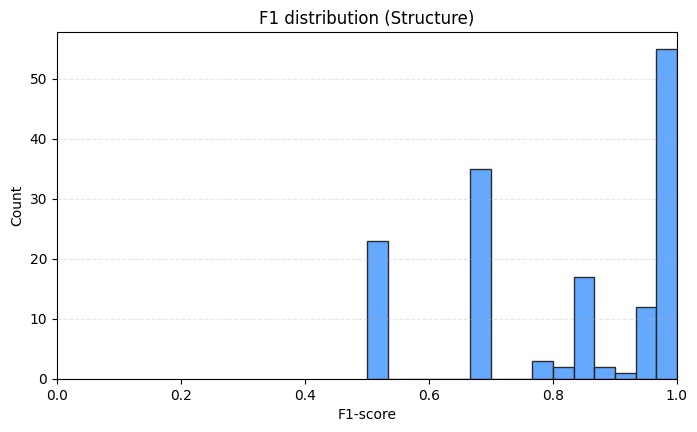

In [ ]:
# Generar histogramas para Structure y Content si existen (para todos los modelos)
figures_dir = './figures'
for model_name, df in dfs:
    if 'Structure_hierarchical_precision' in df.columns and 'Structure_hierarchical_recall' in df.columns:
        hist_f1(df, 'Structure_hierarchical_precision', 'Structure_hierarchical_recall', 'F1 distribution (Structure)', f'{figures_dir}/{model_name}_hist_f1_structure.png', bins=15)
    else:
        print(f'{model_name}: Structure columns not found; skipping Structure F1 histogram.')

## Histogram Accuracy

Figure saved to: figures/GPT-5.1_hist_content_accuracy.png


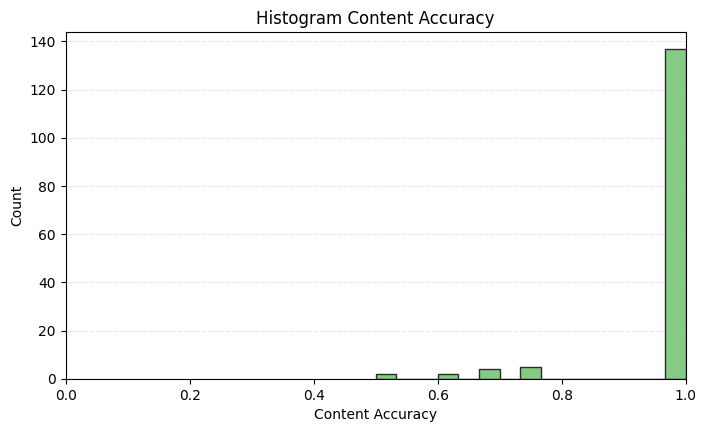

Figure saved to: figures/GPT-5-Mini_hist_content_accuracy.png


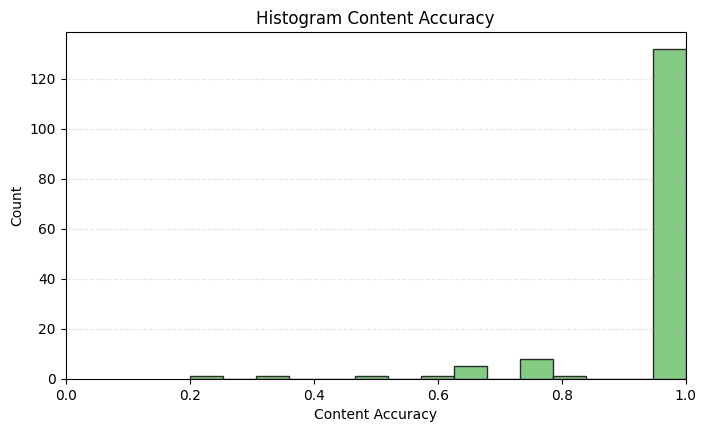

Figure saved to: figures/GPT-5-Nano_hist_content_accuracy.png


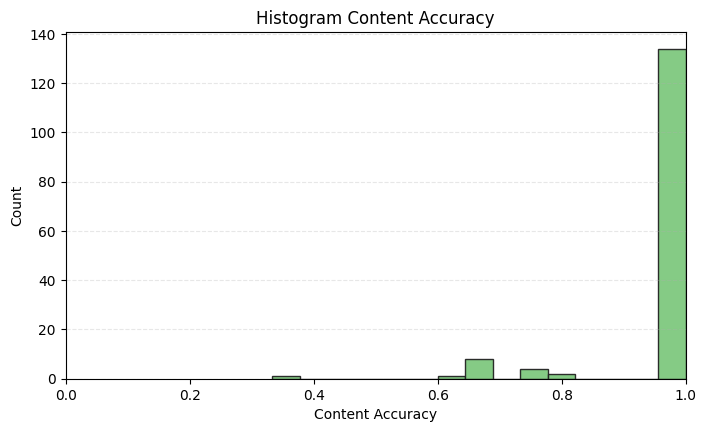

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import pandas as pd

def hist_content_accuracy(df: pd.DataFrame, col: str = 'Content_Accuracy', title: str = 'Content Accuracy distribution', out_path='./figures/hist_content_accuracy.png', bins: int = 20, show: bool = True, color: str = '#7FC97F'):
    """Genera un histograma de la columna `Content_Accuracy`.

    Parámetros:
    - df: pandas.DataFrame que contiene la columna de accuracy de content.
    - col: nombre de la columna a usar.
    - title: título de la figura.
    - out_path: ruta donde guardar la imagen.
    - bins: número de bins del histograma.
    - show: mostrar la figura en el notebook.
    - color: color del histograma.
    """
    out_path = Path(out_path)

    if col not in df.columns:
        raise ValueError(f'Required column not found: {col}')

    vals = df[col].astype(float).fillna(0).to_numpy()

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(vals, bins=bins, color=color, edgecolor='#222222', alpha=0.95)

    ax.set_xlim(0, 1)
    ax.set_xlabel('Content Accuracy')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    print(f'Figure saved to: {out_path}')
    if show:
        display(fig)
    plt.close(fig)

# Generar histograma de Content_Accuracy para todos los modelos en `dfs`
figures_dir = './figures'
for model_name, df in dfs:
    if 'Content_accuracy' in df.columns:
        hist_content_accuracy(df, 'Content_accuracy', 'Histogram Content Accuracy', f'{figures_dir}/{model_name}_hist_content_accuracy.png', bins=15)
    else:
        print(f'{model_name}: Content_accuracy column not found; skipping Content Accuracy histogram.')

## KDE comparison

KDE figure saved to: figures/kde_f1_structure_comparison.png


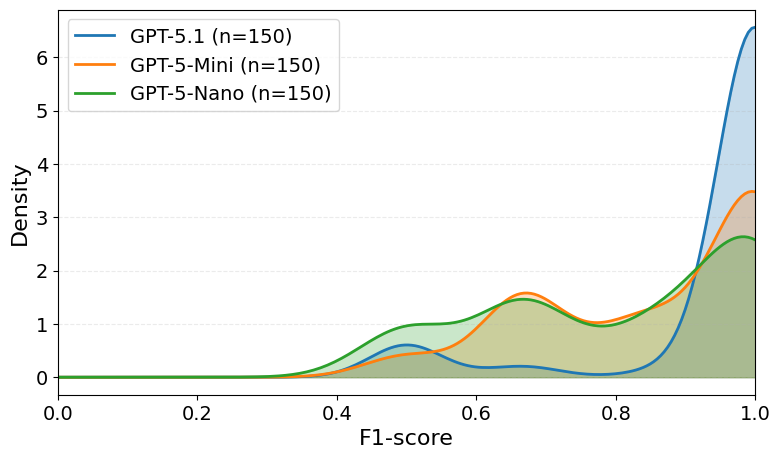

In [109]:
# KDE comparison: función para comparar F1 entre varios `df` en `dfs`
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from scipy.stats import gaussian_kde


def compare_kde_f1(
    dfs,
    recall_col: str,
    precision_col: str,
    title: str = 'KDE F1 comparison',
    out_path: str | None = None,
    grid_points: int = 200,
    fill: bool = True,
    alpha: float = 0.25,
    linewidth: float = 2.0,
    cmap: str = 'tab10',
    show: bool = True,
    label_fontsize: int = 14,
    tick_fontsize: int = 12,
    legend_fontsize: int = 12,
):
    """Genera una figura con las curvas KDE de la distribución de F1 de cada DataFrame en `dfs`.

    Parámetros:
    - dfs: iterable de tuplas (model_name, df).
    - recall_col, precision_col: nombres de las columnas a usar para calcular F1.
    - title: título de la figura (opcional, no se muestra para reducir ruido).
    - out_path: si se proporciona, ruta donde guardar la imagen.
    - grid_points: resolución de la malla sobre [0,1].
    - fill: rellenar bajo la curva.
    - alpha: transparencia del relleno.
    - linewidth: grosor de las líneas.
    - cmap: colormap a usar para diferenciar curvas.
    - show: si mostrar la figura en el notebook.
    - label_fontsize: tamaño de letra para labels de ejes.
    - tick_fontsize: tamaño de letra para ticks (valores de ejes).
    - legend_fontsize: tamaño de letra para la leyenda.
    """

    grid = np.linspace(0, 1, grid_points)
    colors = plt.get_cmap(cmap)

    fig, ax = plt.subplots(figsize=(9, 5))

    any_plotted = False
    for i, (model_name, df) in enumerate(dfs):
        if recall_col not in df.columns or precision_col not in df.columns:
            print(f"{model_name}: columnas {recall_col}/{precision_col} no encontradas — se omite.")
            continue

        r = df[recall_col].astype(float).fillna(0).to_numpy()
        p = df[precision_col].astype(float).fillna(0).to_numpy()
        denom = (p + r)
        f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)
        f1 = f1[~np.isnan(f1)]
        f1 = f1[np.isfinite(f1)]

        if f1.size == 0:
            print(f"{model_name}: no hay valores válidos de F1 — se omite.")
            continue

        color = colors(i % colors.N)

        if f1.size < 2:
            # Pocos datos: dibujar pequeño hist tipo rug/marker
            ax.hist(f1, bins=5, density=True, histtype='step', color=color, linewidth=1.5, label=f"{model_name} (n={len(f1)})")
            ax.plot(f1, np.full_like(f1, 0.0), '|', color=color, markersize=12)
            any_plotted = True
            continue

        try:
            kde = gaussian_kde(f1)
            y = kde(grid)
            ax.plot(grid, y, label=f"{model_name} (n={len(f1)})", color=color, linewidth=linewidth)
            if fill:
                ax.fill_between(grid, y, alpha=alpha, color=color)
            any_plotted = True
        except Exception as e:
            # Fallback: histograma suavizado
            print(f"{model_name}: no se pudo calcular KDE ({e}). Dibujando histograma en su lugar.")
            histy, bins = np.histogram(f1, bins=30, density=True)
            bincenters = 0.5 * (bins[1:] + bins[:-1])
            ax.plot(bincenters, histy, label=f"{model_name} (hist)", color=color, linewidth=linewidth)
            any_plotted = True

    if not any_plotted:
        ax.text(0.5, 0.5, 'No hay datos válidos para comparar', ha='center', va='center')

    ax.set_xlim(0, 1)
    ax.set_xlabel('F1-score', fontsize=label_fontsize)
    ax.set_ylabel('Density', fontsize=label_fontsize)
    # Title intentionally omitted to reduce clutter
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.legend(loc='upper left', fontsize=legend_fontsize)

    if out_path:
        outp = Path(out_path)
        outp.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outp, bbox_inches='tight', dpi=150)
        print(f'KDE figure saved to: {outp}')

    if show:
        display(fig)
    plt.close(fig)


# Ejemplo de uso: comparar F1 para "Structure" si las columnas existen
figures_dir = './figures'
if any(('Structure_hierarchical_recall' in df.columns and 'Structure_hierarchical_precision' in df.columns) for _, df in dfs):
    compare_kde_f1(
        dfs,
        recall_col='Structure_hierarchical_recall',
        precision_col='Structure_hierarchical_precision',
        title='KDE: F1 Comparison (Structure)',
        out_path=f'{figures_dir}/kde_f1_structure_comparison.png',
        fill=True,
        label_fontsize=16,
        tick_fontsize=14,
        legend_fontsize=14,
    )
else:
    print('No se detectan columnas Structure_hierarchical_* en los dfs; no se generó KDE de Structure.')

## Ridgeline plot Comparative

Ridgeline figure saved to: figures/ridgeline_f1_structure.png


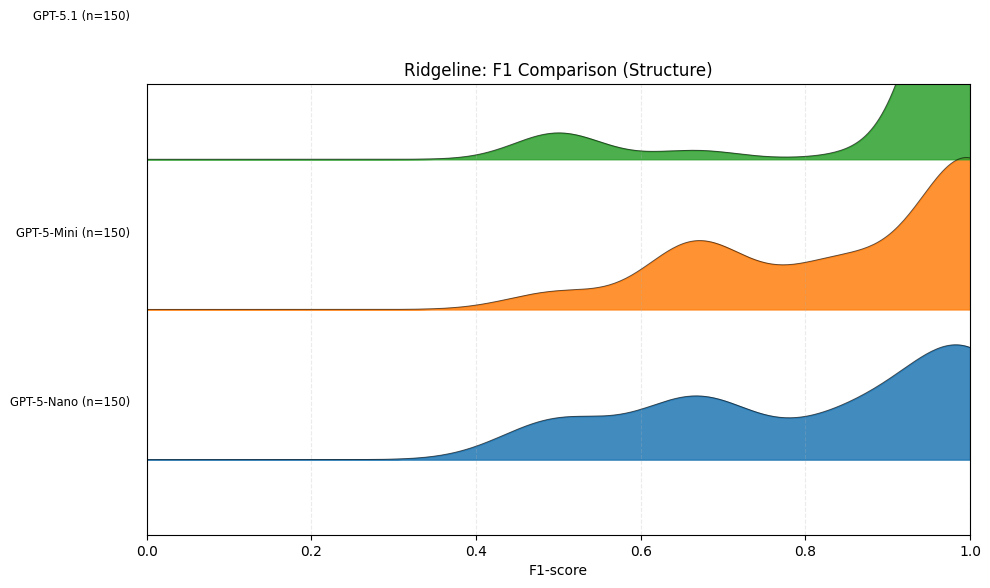

In [ ]:
# Ridgeline plot Comparative: compara F1 entre varios `df` en `dfs` con curvas apiladas
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from scipy.stats import gaussian_kde


def ridgeline_f1(
    dfs,
    recall_col: str,
    precision_col: str,
    title: str = 'Ridgeline: F1 comparison',
    out_path: str | None = None,
    grid_points: int = 300,
    overlap: float = 0.6,
    cmap: str = 'tab10',
    figsize=(10, 6),
    show: bool = True,
):
    """Dibuja un ridgeline plot (curvas KDE apiladas) de F1 para cada (model_name, df) en `dfs`.

    - `overlap` controla cuánto se solapan las curvas (0..1). Valores cerca de 1 => más solapadas.
    - Si un modelo tiene <2 valores válidos, se marca con un "rug" y/o hist pequeño.
    """

    # Preparación
    grid = np.linspace(0, 1, grid_points)
    colors = plt.get_cmap(cmap)

    series = []  # list of (model_name, f1_array)
    for model_name, df in dfs:
        if recall_col not in df.columns or precision_col not in df.columns:
            print(f"{model_name}: columnas {recall_col}/{precision_col} no encontradas — se omite.")
            continue
        r = df[recall_col].astype(float).fillna(0).to_numpy()
        p = df[precision_col].astype(float).fillna(0).to_numpy()
        denom = (p + r)
        f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)
        f1 = f1[np.isfinite(f1)]
        f1 = f1[~np.isnan(f1)]
        if f1.size == 0:
            print(f"{model_name}: no hay valores válidos de F1 — se omite.")
            continue
        series.append((model_name, f1))

    if not series:
        print('No hay series válidas para dibujar el ridgeline.')
        return

    # Calcular densidades
    densities = []
    max_peak = 0.0
    for _, f1 in series:
        if f1.size >= 2:
            try:
                kde = gaussian_kde(f1)
                y = kde(grid)
            except Exception:
                histy, bins = np.histogram(f1, bins=30, density=True)
                bincenters = 0.5 * (bins[1:] + bins[:-1])
                # interpolar al grid
                y = np.interp(grid, bincenters, histy, left=0, right=0)
        else:
            # tratar un solo punto como delta aproximado con una pequeña gaussiana
            y = np.exp(-0.5 * ((grid - f1.ravel()[0]) / 0.01) ** 2)
            y = y / (y.sum() + 1e-12)
        densities.append(y)
        max_peak = max(max_peak, y.max())

    # Ajuste vertical
    n = len(densities)
    # separación vertical base: escalar por max_peak y overlap
    vertical_spacing = max_peak * (1.0 - overlap) * 1.5
    if vertical_spacing <= 0:
        vertical_spacing = max_peak * 0.2 + 0.1

    fig, ax = plt.subplots(figsize=figsize)

    # Ordenar series por mediana para apariencia (opcional)
    order = sorted(range(n), key=lambda i: np.median(series[i][1]))

    for rank, idx in enumerate(order):
        model_name, f1 = series[idx]
        y = densities[idx]
        # escala local para mantener forma legible
        scale = 1.0  # ya y está en densidad
        offset = rank * vertical_spacing
        color = colors(rank % colors.N)

        # rellenar entre offset y offset + y*scale
        ax.fill_between(grid, offset, y * scale + offset, color=color, alpha=0.85)
        ax.plot(grid, y * scale + offset, color='k', linewidth=0.7, alpha=0.6)

        # añadir etiqueta a la izquierda de la cresta
        ax.text(-0.02, offset + (y.max() * 0.5), f"{model_name} (n={len(f1)})", va='center', ha='right', fontsize='small')

        # si pocos datos, dibujar rug
        if len(f1) < 10:
            ax.plot(f1, np.full_like(f1, offset + 0.02), '|', color='k', markersize=8, alpha=0.8)

    ax.set_xlim(0, 1)
    ax.set_ylim(-vertical_spacing * 0.5, vertical_spacing * (n - 0.5))
    ax.set_xlabel('F1-score')
    ax.set_yticks([])
    ax.set_title(title)
    ax.grid(axis='x', linestyle='--', alpha=0.25)

    # tidy
    plt.tight_layout()

    if out_path:
        outp = Path(out_path)
        outp.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outp, bbox_inches='tight', dpi=150)
        print(f'Ridgeline figure saved to: {outp}')

    if show:
        display(fig)
    plt.close(fig)


# Ejemplo de uso: generar ridgeline para Structure (si existen las columnas)
figures_dir = './figures'
if any(('Structure_hierarchical_recall' in df.columns and 'Structure_hierarchical_precision' in df.columns) for _, df in dfs):
    ridgeline_f1(
        dfs,
        recall_col='Structure_hierarchical_recall',
        precision_col='Structure_hierarchical_precision',
        title='Ridgeline: F1 Comparison (Structure)',
        out_path=f'{figures_dir}/ridgeline_f1_structure.png',
        overlap=0.65,
    )
else:
    print('No se detectan columnas Structure_hierarchical_* en los dfs; no se generó ridgeline de Structure.')


## Statistic relevance